# Week HW 18

Last Audit: HW18

注意：
1. Model
- 變數改為 Constant
- 加入 try except
- train 之前清空變數
2. 最後檢查
- 變數名稱一致
- 變數 return 與 接用 順序是否一致
3. Testing
- model parameter 可能 load 不到
- 訓練結果（result）可能是空的
4. Analysis
- 抓數值或結果時，要小心 None 的出現


*** 開發時記得 commit





# Pips


In [3]:
%pip install gurobipy>=10
%pip install gurobipy_pandas
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

zsh:1: 10 not found
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 5.8 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.6 MB/s eta 0:00:00

[notice] A new release of 

# Import


In [4]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [ ]:
data_size = 10
train_size = 0.8
testing_size = 0.2

# data_size = 10 # 最小要是 2
# train_size = 1
# testing_size = 0

T = 10
service_level = 0.95  # 服務水準
M = 5000000

assigned_Fs = np.arange(0.1, 1.0, 0.1)
assigned_Ts = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

current_timestamp = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [ ]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    data_size=data_size,
    current_timestamp=current_timestamp,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(f"Model parameters saved as models/{name}.pkl")
    else:
        print("No parameters provided to save.")

In [1]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{current_timestamp}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [3]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

## Others

In [64]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [65]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [66]:
# Calculate service level


def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [ ]:
def plot_strategies_profits_scatter(dfs):
    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if dfs[i] is None or dfs[j] is None:
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(
            profits_i, profits_j, alpha=0.6, label=f"Profits {i+1} vs Profits {j+1}"
        )
        ax.set_xlabel(f"Profits {i+1}")
        ax.set_ylabel(f"Profits {j+1}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i+1} vs Profits {j+1}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
def plot_relative_profit_deviation(baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    # 顯示圖表
    plt.show()

In [69]:
def make_s3_related_strtegies_result(
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
):

    results_dict = {
        "R": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "alpha_values": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }
    # 计算平均值
    average_losses = sum(losses) / len(losses) if losses else 0
    average_lefts = sum(lefts) / len(lefts) if lefts else 0
    average_profits = sum(profits) / len(profits) if profits else 0
    average_operation_profits = (
        sum(operation_profits) / len(operation_profits) if operation_profits else 0
    )

    # 将结果存储到字典中
    results_dict["R"].append(all_Rs)
    results_dict["average_losses"].append(average_losses)
    results_dict["average_lefts"].append(average_lefts)
    results_dict["average_profits"].append(average_profits)
    results_dict["average_operation_profits"].append(average_operation_profits)
    results_dict["alpha_values"].append(alpha_values)
    results_dict["beta_values"].append(beta_values)
    results_dict["F_vars"].append(F_vars)
    results_dict["Q0_vars"].append(Q0_vars)
    results_dict["Q1_vars"].append(Q1_vars)

    max_profit_stimulation_result = {
        "R": all_Rs,
        "F": F_vars,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
    }

    print(f"alpha_values: \n{alpha_values}")
    print(f"f_values: \n{f_values}")
    print(f"tau_values: \n{tau_values}")
    print(f"beta: \n{beta_values}")

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

# Import Data


## Data1: Training data for LR


### Making full data


In [337]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(80, 90, data_size),
        "X2": np.random.randint(1, 4, data_size),
    }
)

full_df

,X1,X2
0,85.488135,3
1,87.151894,1
2,86.027634,2
3,85.448832,2
4,84.236548,3
5,86.458941,1
6,84.375872,2
7,88.917730,2
8,89.636628,2
9,83.834415,1


In [338]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [339]:
training_df, testing_df = (
    full_df[: int(data_size * train_size)],
    full_df[int(data_size * train_size) :],
)
print(f"training_data size: {training_df.shape}")
print(f"testing_df size: {testing_df.shape}")

training_data size: (16, 2)
testing_df size: (4, 2)


In [340]:
# #### Only for testing
# training_df = testing_df = full_df

## Data2: demand_df


### mu of each time(t)


In [341]:
# 設定 b0, b1, b2
b0 = 0
b1 = 0.17
b2 = 0.01


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    # 設定隨機種子
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 + random_noises[t - 1]
        )

    return mu_matrix

In [342]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (20, 10)
mu_matrix[0]: 
[16.3270353  14.96314017 15.54172094 16.80387616 16.43054095 13.58570508
 15.51307137 14.41162575 14.4597641  14.97358146]


### sigma matrix


In [343]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[-0.12593609  0.39526239 -0.87954906  0.33353343  0.34127574 -0.57923488
  -0.7421474  -0.3691433  -0.27257846  0.14039354]
 [-0.12279697  0.97674768 -0.79591038 -0.58224649 -0.67738096  0.30621665
  -0.49341679 -0.06737845 -0.51114882 -0.68206083]]


In [344]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((20, 10),
 array([[6.33962255, 8.57873649, 4.30896461, 5.94552029, 5.76807482,
         6.67602145, 4.96290496, 6.18183316, 5.42343077, 5.54020243],
        [6.3417756 , 8.44618042, 4.30321694, 6.26509127, 6.12445957,
         6.37878351, 4.89804711, 6.0832969 , 5.51455209, 5.82978508],
        [6.4519222 , 7.92390401, 4.94931996, 6.57960146, 6.50256833,
         6.30277772, 5.37411811, 6.21161838, 5.91865713, 6.25838967],
        [6.38884974, 8.33631163, 4.58232804, 6.17345972, 6.03349463,
         6.56206346, 5.15300694, 6.21135712, 5.62513907, 5.80742419],
        [6.57916252, 7.24252343, 5.78569915, 6.85070621, 6.83547072,
         6.30009478, 5.97347039, 6.38906489, 6.36611822, 6.6702511 ],
        [6.39785249, 8.20429894, 4.62283156, 6.4033117 , 6.2924086 ,
         6.36168537, 5.1423411 , 6.15584812, 5.71320538, 6.02744396],
        [6.56969352, 7.29648329, 5.72151549, 6.83167648, 6.81204214,
         6.29931802, 5.9280493 , 6.37552407, 6.3331389 , 6.64076637],
        [6.26202

### corr matrix


In [345]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [346]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (20, 10, 10)
cov_matrices: 
[[ 40.19081404  19.26583117  15.1824569   22.14089021 -14.1798824
   -6.83457249  -3.11712204 -10.81436697 -16.80930612  -0.73493371]
 [ 19.26583117  73.59471973  23.86754584  17.55842895 -26.42194581
   -6.79898946 -15.6081998    3.83053217   5.11593378  -2.3348731 ]
 [ 15.1824569   23.86754584  18.56717602   6.65398111 -10.64991617
   -6.80392192 -11.79474146   0.28135771  -9.68067088  -3.07260357]
 [ 22.14089021  17.55842895   6.65398111  35.34921148 -14.87393057
   -3.134176     4.90503621 -23.19270162   2.87430238   8.04303616]
 [-14.1798824  -26.42194581 -10.64991617 -14.87393057  33.27068713
   14.30175679   8.59680608  10.4839412   -4.80876272  -3.46881088]
 [ -6.83457249  -6.79898946  -6.80392192  -3.134176    14.30175679
   44.56926245  21.81082318  21.48137613 -12.37327815   5.4525029 ]
 [ -3.11712204 -15.6081998  -11.79474146   4.90503621   8.59680608
   21.81082318  24.63042563   1.19471563  -0.26302138  13.35924634]
 [-10.81

In [347]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [348]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,15.149571,0.919201,13.117152,16.026997,32.406037,25.646739,21.142896,12.946388,2.853504,6.366686
1,14.820273,19.769059,20.223773,17.134775,17.770991,23.809967,17.899704,20.724131,9.788866,15.537322
2,24.093517,38.361010,24.468495,29.877199,1.019930,16.569815,13.466286,11.655393,14.553809,6.694014
3,6.350284,19.866380,16.609759,13.402230,14.010679,13.918944,10.982348,22.206259,22.356895,19.538705
4,22.504553,8.285953,9.158667,24.424620,9.244425,-0.329366,11.111848,-3.127070,21.842476,13.142457
5,15.876746,26.372214,19.097529,16.853128,12.410583,9.787082,11.097521,15.768189,19.154312,16.918201
6,16.168944,25.098576,13.454486,16.039032,7.790059,10.039626,11.752440,17.561641,24.419830,18.458708
7,20.690942,7.338685,13.165185,17.311284,20.308674,21.082412,22.147670,13.538368,8.145661,12.565968
8,14.304293,27.446173,11.520192,24.103697,4.450405,14.823462,18.310294,9.439115,25.796754,16.335694
9,20.979815,18.566320,21.048779,14.481228,19.956911,12.412171,13.948520,12.756569,5.150738,7.751551


### Replace negative values to 0


In [349]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,15.149571,0.919201,13.117152,16.026997,32.406037,25.646739,21.142896,12.946388,2.853504,6.366686
1,14.820273,19.769059,20.223773,17.134775,17.770991,23.809967,17.899704,20.724131,9.788866,15.537322
2,24.093517,38.361010,24.468495,29.877199,1.019930,16.569815,13.466286,11.655393,14.553809,6.694014
3,6.350284,19.866380,16.609759,13.402230,14.010679,13.918944,10.982348,22.206259,22.356895,19.538705
4,22.504553,8.285953,9.158667,24.424620,9.244425,0.000000,11.111848,0.000000,21.842476,13.142457
5,15.876746,26.372214,19.097529,16.853128,12.410583,9.787082,11.097521,15.768189,19.154312,16.918201
6,16.168944,25.098576,13.454486,16.039032,7.790059,10.039626,11.752440,17.561641,24.419830,18.458708
7,20.690942,7.338685,13.165185,17.311284,20.308674,21.082412,22.147670,13.538368,8.145661,12.565968
8,14.304293,27.446173,11.520192,24.103697,4.450405,14.823462,18.310294,9.439115,25.796754,16.335694
9,20.979815,18.566320,21.048779,14.481228,19.956911,12.412171,13.948520,12.756569,5.150738,7.751551


### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [350]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,153.010061,146.575171,20.551797,9.391833,118.826253
1,155.638451,177.478861,20.559220,3.647259,463.689541
2,153.827209,180.759468,21.074002,10.608636,98.649491
3,152.843246,159.242481,20.779188,4.899428,324.114558
4,150.882363,119.715000,21.672147,8.253106,162.593838
5,154.460432,163.335504,20.820191,4.507472,361.903938
6,151.019214,160.783342,21.627783,5.381272,301.908377
7,158.740373,156.294847,20.198450,5.168544,290.795770
8,159.962499,166.530079,20.599238,7.032879,192.899101
9,149.998738,147.052601,21.387383,5.209792,310.522751


### Validate normal distribution


In [351]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,15.149571,0.919201,13.117152,16.026997,32.406037,25.646739,21.142896,12.946388,2.853504,6.366686
1,14.820273,19.769059,20.223773,17.134775,17.770991,23.809967,17.899704,20.724131,9.788866,15.537322
2,24.093517,38.361010,24.468495,29.877199,1.019930,16.569815,13.466286,11.655393,14.553809,6.694014
3,6.350284,19.866380,16.609759,13.402230,14.010679,13.918944,10.982348,22.206259,22.356895,19.538705
4,22.504553,8.285953,9.158667,24.424620,9.244425,0.000000,11.111848,0.000000,21.842476,13.142457
5,15.876746,26.372214,19.097529,16.853128,12.410583,9.787082,11.097521,15.768189,19.154312,16.918201
6,16.168944,25.098576,13.454486,16.039032,7.790059,10.039626,11.752440,17.561641,24.419830,18.458708
7,20.690942,7.338685,13.165185,17.311284,20.308674,21.082412,22.147670,13.538368,8.145661,12.565968
8,14.304293,27.446173,11.520192,24.103697,4.450405,14.823462,18.310294,9.439115,25.796754,16.335694
9,20.979815,18.566320,21.048779,14.481228,19.956911,12.412171,13.948520,12.756569,5.150738,7.751551


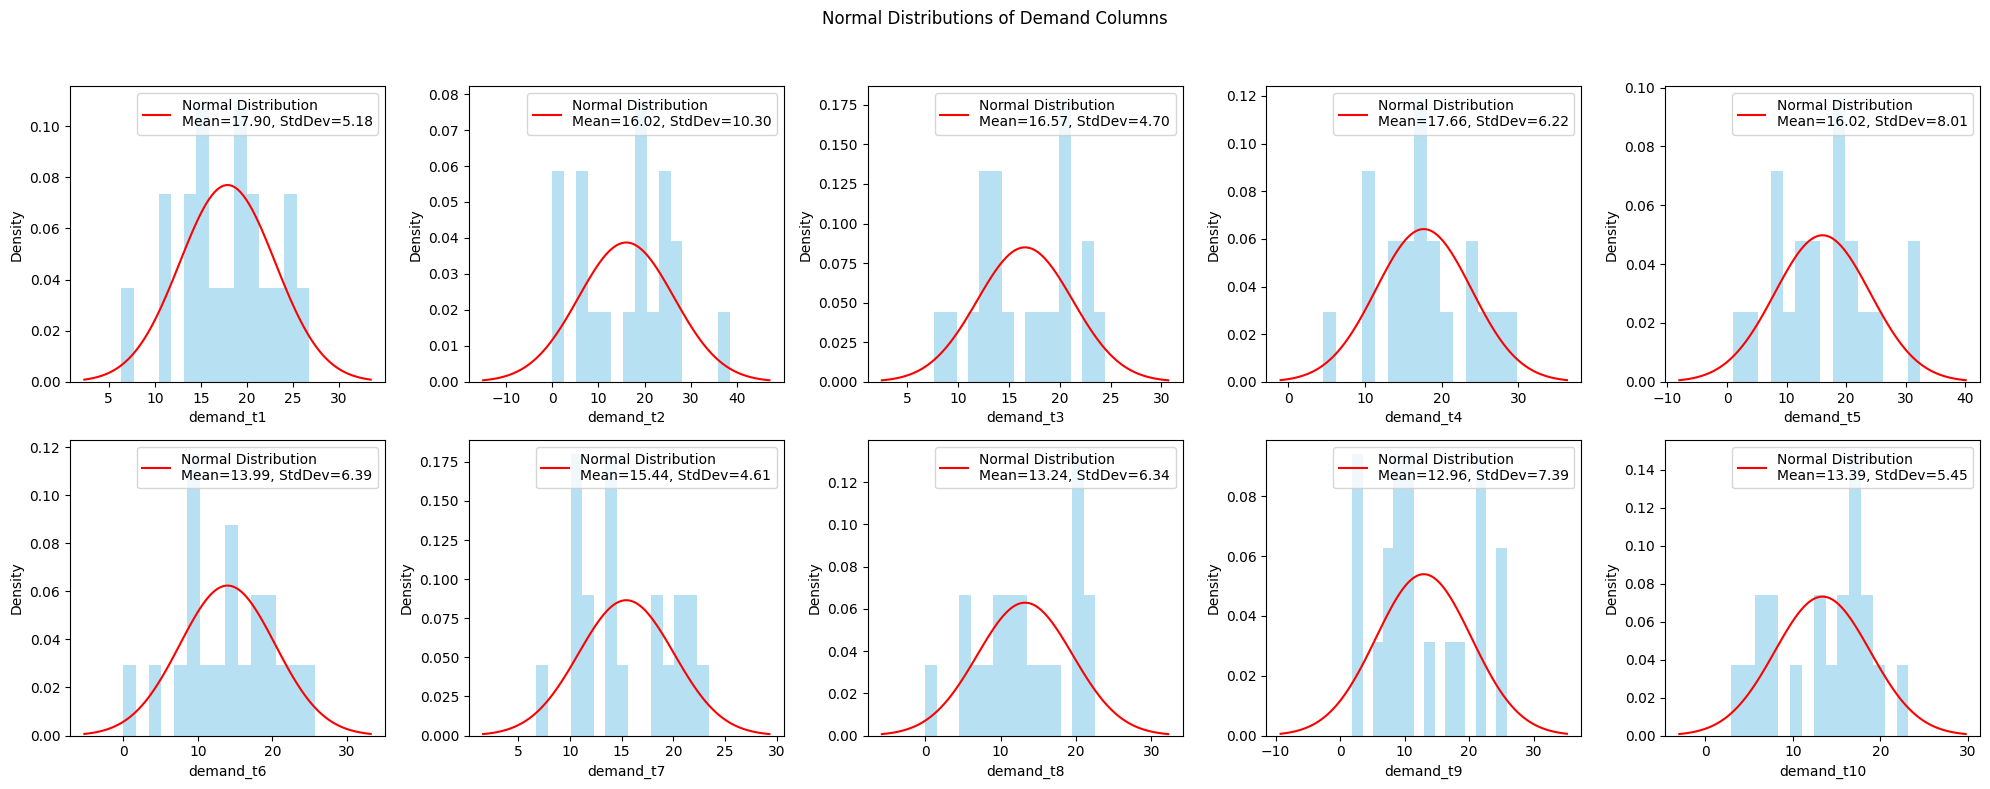

In [352]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [353]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,28.255702,10.152969,7.497361,19.403852,-13.900737,-9.037199,1.451971,-16.346259,-12.853775,-11.418467
demand_t2,10.152969,111.617838,35.172917,37.784227,-69.669494,-2.867674,-23.528822,7.722870,25.058177,-3.432977
demand_t3,7.497361,35.172917,23.213140,9.034889,-14.654402,7.557418,-8.547807,8.622810,-13.398921,-9.780695
demand_t4,19.403852,37.784227,9.034889,40.740398,-34.173948,-13.174175,-7.610943,-26.918881,13.393545,-11.749788
demand_t5,-13.900737,-69.669494,-14.654402,-34.173948,67.522901,14.420524,12.931915,4.851629,-29.110121,-4.959211
demand_t6,-9.037199,-2.867674,7.557418,-13.174175,14.420524,43.028281,14.571510,27.908889,-28.060676,-4.890520
demand_t7,1.451971,-23.528822,-8.547807,-7.610943,12.931915,14.571510,22.369041,5.240905,-11.170244,9.137452
demand_t8,-16.346259,7.722870,8.622810,-26.918881,4.851629,27.908889,5.240905,42.271639,-12.321081,12.468904
demand_t9,-12.853775,25.058177,-13.398921,13.393545,-29.110121,-28.060676,-11.170244,-12.321081,57.502441,22.195593
demand_t10,-11.418467,-3.432977,-9.780695,-11.749788,-4.959211,-4.890520,9.137452,12.468904,22.195593,31.299582


In [354]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,13.114853,8.122732,9.918565,4.936292,1.923990,2.399448,4.843572,5.316039,5.471436,10.596172
demand_t2,8.122732,46.896850,10.180024,20.006470,42.527285,3.220312,7.974977,4.125496,19.935989,1.030959
demand_t3,9.918565,10.180024,0.899353,0.886398,1.404645,14.925586,5.907195,8.302392,1.575479,5.940128
demand_t4,4.936292,20.006470,0.886398,0.838311,16.409366,9.929111,13.306656,1.671423,10.045409,21.377311
demand_t5,1.923990,42.527285,1.404645,16.409366,27.171356,0.608470,2.793374,6.734288,23.421762,0.742535
demand_t6,2.399448,3.220312,14.925586,9.929111,0.608470,2.117646,7.837451,7.223199,15.338629,10.637103
demand_t7,4.843572,7.974977,5.907195,13.306656,2.793374,7.837451,6.167126,3.950990,10.866107,6.681732
demand_t8,5.316039,4.125496,8.302392,1.671423,6.734288,7.223199,3.950990,3.632997,4.941958,7.515706
demand_t9,5.471436,19.935989,1.575479,10.045409,23.421762,15.338629,10.866107,4.941958,23.474072,9.533760
demand_t10,10.596172,1.030959,5.940128,21.377311,0.742535,10.637103,6.681732,7.515706,9.533760,6.109176


### Validate the corr matrix of damand_df is close to original setting


In [355]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.180789,0.292744,0.571903,-0.318243,-0.259181,0.057754,-0.472978,-0.318885,-0.383960
demand_t2,0.180789,1.000000,0.690995,0.560314,-0.802510,-0.041380,-0.470879,0.112431,0.312780,-0.058081
demand_t3,0.292744,0.690995,1.000000,0.293794,-0.370148,0.239127,-0.375115,0.275269,-0.366741,-0.362855
demand_t4,0.571903,0.560314,0.293794,1.000000,-0.651564,-0.314654,-0.252117,-0.648664,0.276719,-0.329040
demand_t5,-0.318243,-0.802510,-0.370148,-0.651564,1.000000,0.267534,0.332747,0.090811,-0.467170,-0.107874
demand_t6,-0.259181,-0.041380,0.239127,-0.314654,0.267534,1.000000,0.469682,0.654397,-0.564128,-0.133263
demand_t7,0.057754,-0.470879,-0.375115,-0.252117,0.332747,0.469682,1.000000,0.170435,-0.311455,0.345328
demand_t8,-0.472978,0.112431,0.275269,-0.648664,0.090811,0.654397,0.170435,1.000000,-0.249909,0.342795
demand_t9,-0.318885,0.312780,-0.366741,0.276719,-0.467170,-0.564128,-0.311455,-0.249909,1.000000,0.523184
demand_t10,-0.383960,-0.058081,-0.362855,-0.329040,-0.107874,-0.133263,0.345328,0.342795,0.523184,1.000000


In [356]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [376]:
demand_df_train, demand_df_test = (
    demand_df[: int(data_size * train_size)],
    demand_df[int(data_size * train_size) :],
)
print(f"demand_df_train size: {demand_df_train.shape}")
print(f"demand_df_test size: {demand_df_test.shape}")

demand_df_train size: (16, 10)
demand_df_test size: (4, 10)


In [358]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [385]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [386]:
Q_star = calculate_Q_star(demand_df_train, service_level=0.95)

mean of sum: 153.00849680557707
std of sum: 17.232077124536602
95.0 percentile of sum: 181.3527413637786


## Data3: Qk hat df


### Functions


In [392]:
from scipy.stats import multivariate_normal, norm


# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [393]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [394]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    print(f"        mean_Y: {mean_Y}")
    print(f"        sd_Y: {sd_Y}")
    print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [395]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    print(f"mu_matrix: {mu_matrix}")
    print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [396]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            print(f"    x_observed: {x_observed}")
            print(f"    mu_cond: {mu_cond}")
            print(f"    sigma_cond: \n{sigma_cond}")
            print(f"    Qk_hat: {Qk_hat}")
            print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [397]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [398]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [399]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
        mean_Y: 69.23076923076923
        sd_Y: 4.260733053577301
    percentile_95_Y: 76.23905144741786
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

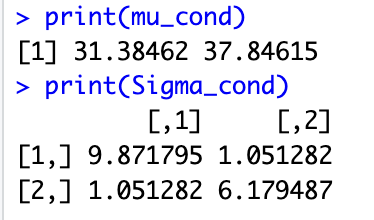
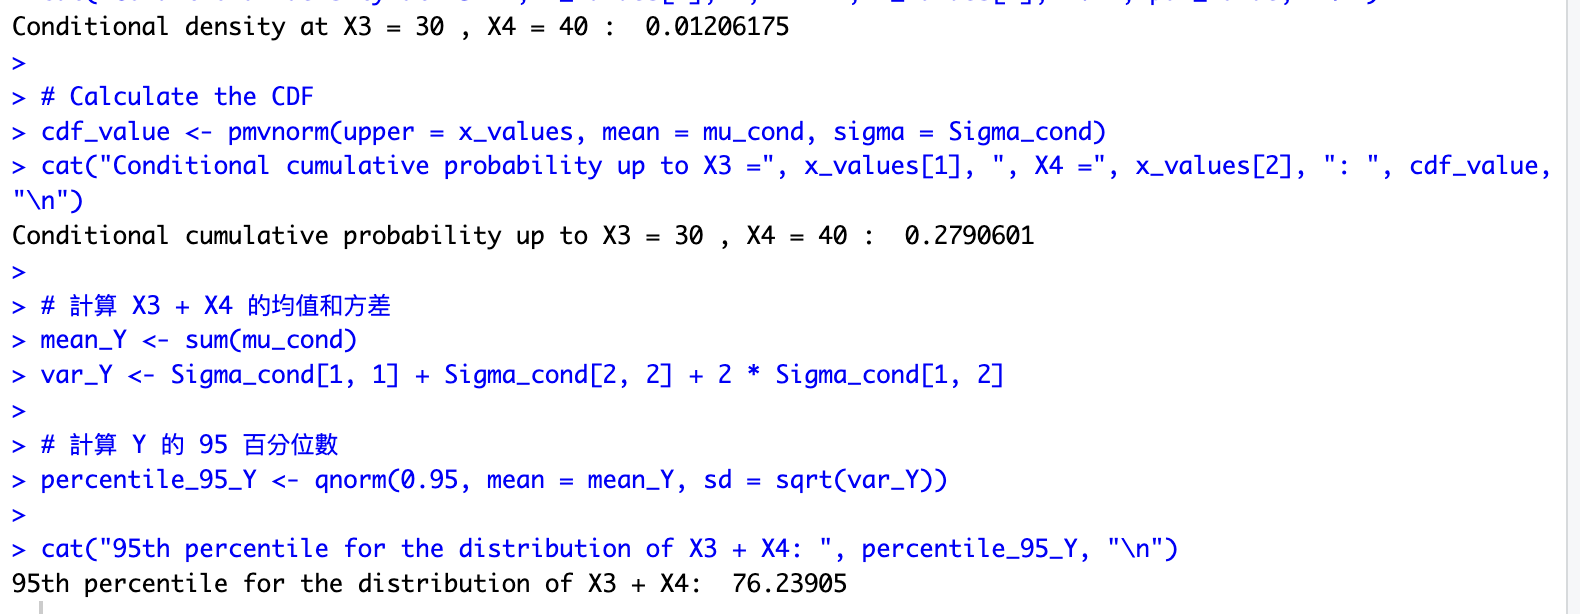


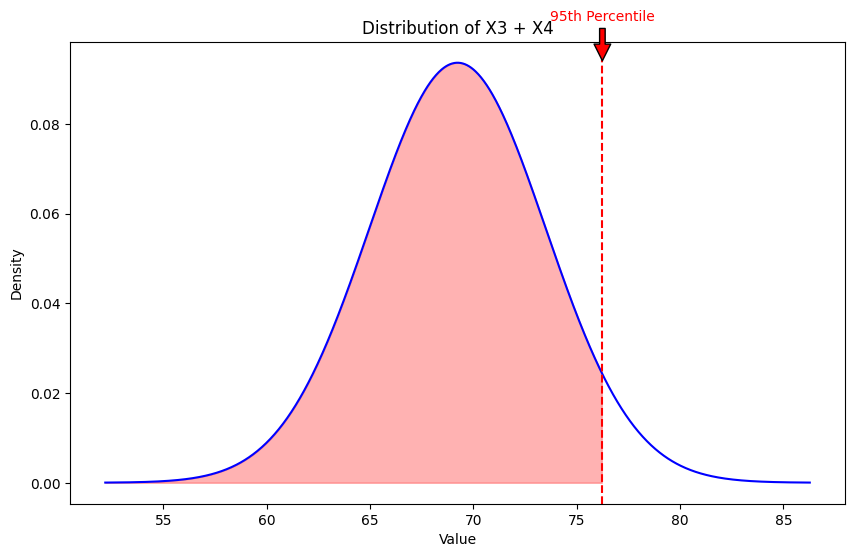

In [400]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


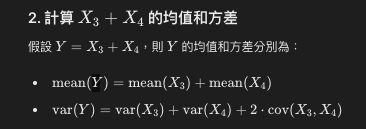


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [401]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.0079302876655625
模擬計算的Y的方差: 3.0261237948892754


### Calculate Qk hat for 2~T-1 of demand_df_train


In [407]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,15.149571,0.919201,13.117152,16.026997,32.406037,25.646739,21.142896,12.946388,2.853504,6.366686
1,14.820273,19.769059,20.223773,17.134775,17.770991,23.809967,17.899704,20.724131,9.788866,15.537322
2,24.093517,38.361010,24.468495,29.877199,1.019930,16.569815,13.466286,11.655393,14.553809,6.694014
3,6.350284,19.866380,16.609759,13.402230,14.010679,13.918944,10.982348,22.206259,22.356895,19.538705
4,22.504553,8.285953,9.158667,24.424620,9.244425,0.000000,11.111848,0.000000,21.842476,13.142457
5,15.876746,26.372214,19.097529,16.853128,12.410583,9.787082,11.097521,15.768189,19.154312,16.918201
6,16.168944,25.098576,13.454486,16.039032,7.790059,10.039626,11.752440,17.561641,24.419830,18.458708
7,20.690942,7.338685,13.165185,17.311284,20.308674,21.082412,22.147670,13.538368,8.145661,12.565968
8,14.304293,27.446173,11.520192,24.103697,4.450405,14.823462,18.310294,9.439115,25.796754,16.335694
9,20.979815,18.566320,21.048779,14.481228,19.956911,12.412171,13.948520,12.756569,5.150738,7.751551


In [402]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

mu_matrix: [16.47671727 16.33159247 16.27278767 17.5119881  15.93524196 14.3671452
 15.08790887 13.31225311 14.21845081 13.49441135]
covariance_matrix: 
[[ 2.27732084e+01  1.25912844e+01  5.72593722e+00  2.17835268e+01
  -1.68672563e+01 -6.71082368e+00  1.05582508e-02 -1.89642664e+01
  -5.93391118e+00 -1.27293024e+01]
 [ 1.25912844e+01  1.31957084e+02  4.00549575e+01  4.22972371e+01
  -8.15250285e+01 -3.85123202e+00 -2.96340077e+01  1.01894916e+01
   3.12539457e+01 -5.61357966e+00]
 [ 5.72593722e+00  4.00549575e+01  2.61002400e+01  8.14011097e+00
  -1.48724308e+01  1.01245166e+01 -1.18492410e+01  1.09820553e+01
  -1.39031747e+01 -1.30548364e+01]
 [ 2.17835268e+01  4.22972371e+01  8.14011097e+00  4.36899659e+01
  -4.15782488e+01 -1.01962259e+01 -6.04351800e+00 -2.65791885e+01
   1.64812704e+01 -1.08468495e+01]
 [-1.68672563e+01 -8.15250285e+01 -1.48724308e+01 -4.15782488e+01
   7.87716432e+01  2.26213469e+01  1.96111253e+01  1.07504977e+01
  -3.90085568e+01 -1.94746277e+00]
 [-6.7108236

In [403]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df = make_Qk_hat_df(
    demand_df_train, T, service_level, mu_matrix, covariance_matrix
)

mu_matrix: [16.47671727 16.33159247 16.27278767 17.5119881  15.93524196 14.3671452
 15.08790887 13.31225311 14.21845081 13.49441135]
covariance_matrix: 
[[ 2.27732084e+01  1.25912844e+01  5.72593722e+00  2.17835268e+01
  -1.68672563e+01 -6.71082368e+00  1.05582508e-02 -1.89642664e+01
  -5.93391118e+00 -1.27293024e+01]
 [ 1.25912844e+01  1.31957084e+02  4.00549575e+01  4.22972371e+01
  -8.15250285e+01 -3.85123202e+00 -2.96340077e+01  1.01894916e+01
   3.12539457e+01 -5.61357966e+00]
 [ 5.72593722e+00  4.00549575e+01  2.61002400e+01  8.14011097e+00
  -1.48724308e+01  1.01245166e+01 -1.18492410e+01  1.09820553e+01
  -1.39031747e+01 -1.30548364e+01]
 [ 2.17835268e+01  4.22972371e+01  8.14011097e+00  4.36899659e+01
  -4.15782488e+01 -1.01962259e+01 -6.04351800e+00 -2.65791885e+01
   1.64812704e+01 -1.08468495e+01]
 [-1.68672563e+01 -8.15250285e+01 -1.48724308e+01 -4.15782488e+01
   7.87716432e+01  2.26213469e+01  1.96111253e+01  1.07504977e+01
  -3.90085568e+01 -1.94746277e+00]
 [-6.7108236

In [404]:
Qk_hat_df

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,181.248989,154.020564,154.353077,154.875210,161.537784,164.477681,155.151757,154.074470
1,181.224712,176.346970,177.102423,177.293965,176.776198,180.011725,178.467770,179.338591
2,181.908382,192.843390,193.044660,193.192790,191.936232,192.739646,190.095402,187.342122
3,180.600262,181.336482,181.313318,181.758723,175.503555,170.901003,165.749034,167.047020
4,181.791235,158.438483,156.947147,157.131572,149.749454,141.284454,126.386605,124.905411
5,181.302600,183.493478,183.396881,183.027196,182.919182,175.140293,170.211015,168.268474
6,181.324143,181.829560,180.309499,179.517389,177.014552,175.853398,162.940018,163.885033
7,181.657527,158.369924,158.074314,157.807436,157.315026,163.436252,157.728702,157.258776
8,181.186671,185.659798,183.477470,183.744860,182.601733,186.333992,184.267035,170.987963
9,181.678824,171.389143,172.315726,171.550873,173.346730,165.951696,162.177041,155.134660


### Plot the distribuction


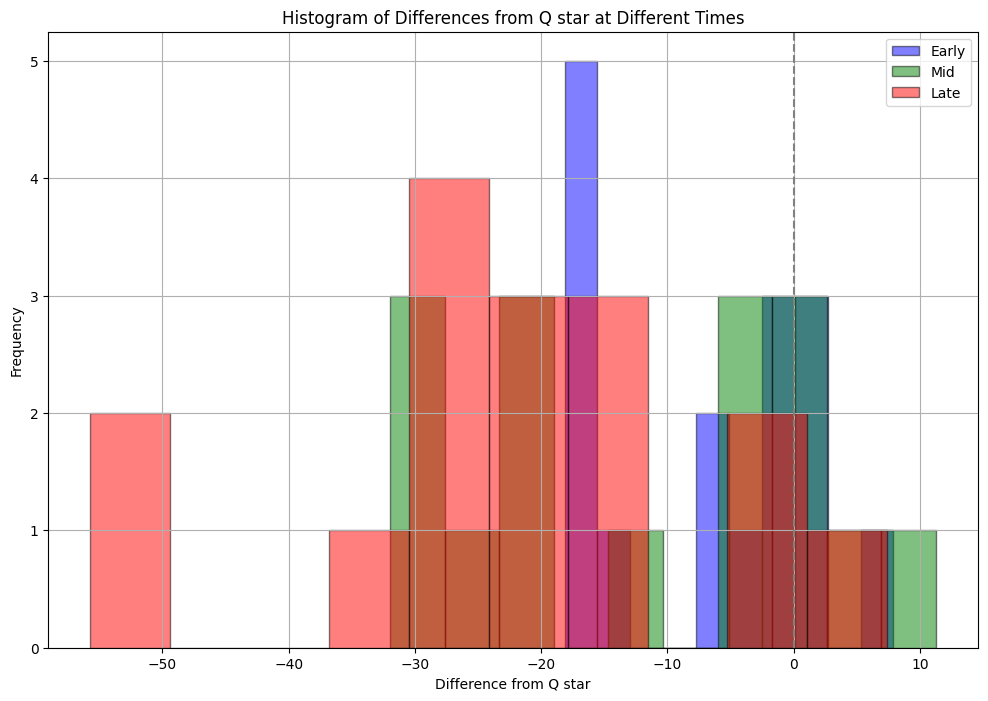

Q_star is: 181.3527413637786
Early bias: -6.690559159317855
Mid bias: -12.181165703969532
Late bias: -22.130453087909352


In [405]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

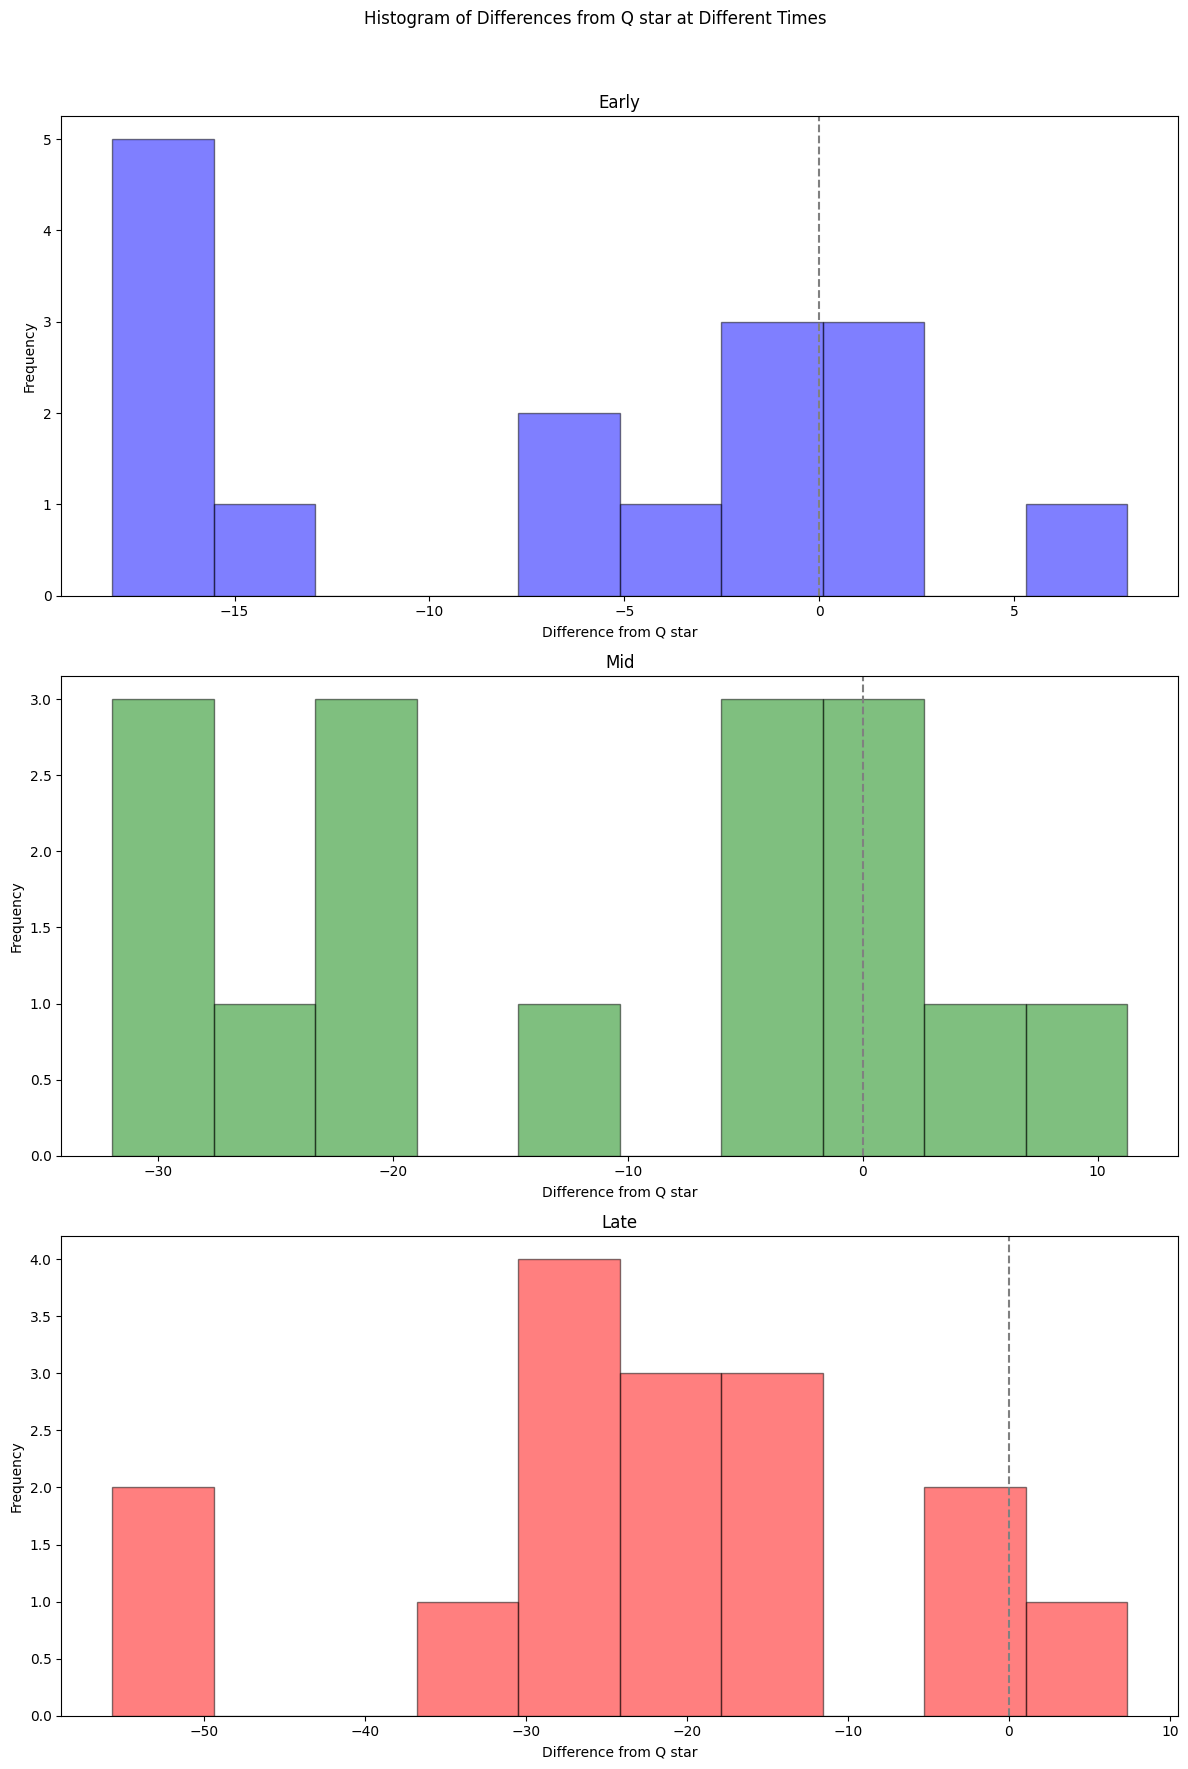

In [406]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## One-time Procurement


In [164]:
def one_time_procurement(Q_star, demand_df):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            # 印出當天的詳細訊息
            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            # 只有最後一天的剩餘物品 Left_1 被計算在內
            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        # 計算每日的運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits

## (1)Grid for Fixed F & Fixed Rk


In [165]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    mean_result = {
        "R": assigned_R + 2,
        "F": assigned_F,
        "Q0": Q0,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
    }

    return mean_result, stimulation_result

In [166]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    print(f"Q_star: {Q_star}")
    results_list = []
    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## (2)Grid for Fixed Rk & Flexible F


In [167]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", 12)
        model.setParam("MIPGap", 0.30)  # 設置相對 MIP gap 為1%

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        # betas = model.addVars(K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept")  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
            print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

            print("===================== 找到最佳解 ==================")
            print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

            print("Alphas values:")
            for key, alpha in alphas.items():
                print(f"alpha[{key}]: {alpha.X}")

            # print("Beta values:")
            # for key, beta in betas.items():
            #     print(f"beta{key}: {beta.X}")

            alpha_values = np.array([alpha.X for key, alpha in alphas.items()])
            # beta_values = np.array([[betas[i, j].X for j in range(1)] for i in range(K)])

            all_losses = []
            all_lefts = []
            all_operation_profits = []
            all_profits = []
            all_Rs = []
            all_Q0s = []
            all_Q1s = []
            all_Fs = []

            for i in range(len(demand_df_train)):

                print("----------------------------------------------")
                print(f"第 {i+1} 筆觀察資料:")

                sold0 = Sold_0s[i].X
                sold1 = Sold_1s[i].X
                left0 = Left_0s[i].X
                left1 = Left_1s[i].X
                lost0 = Lost_0s[i].X
                lost1 = Lost_1s[i].X

                operation_profit = (price - cost) * (sold0 + sold1)
                daily_profit = profits_vars[i].X

                all_losses.append(lost0 + lost1)
                all_lefts.append(left0 + left1)
                all_operation_profits.append(operation_profit)
                all_profits.append(daily_profit)
                all_Q0s.append(Q0_vars[i].X)
                all_Q1s.append(Q1_vars[i].X)
                all_Fs.append(F_vars[i].X)

                reorder_day = None
                for k in range(K):
                    R_value = R_vars[i, k].X
                    print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                    if int(R_value) == 1:
                        reorder_day = k + 2
                print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                all_Rs.append(reorder_day)

                demand_row = demand_df_train.iloc[i]
                print(f"第一階段需求量: {demand_row[: (assigned_R+1)].sum()}")
                print(f"第二階段需求量: {demand_row[(assigned_R+1): ].sum()}\n")

                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                total_demand_down = total_demand_from_k_to_T_vars[i].X

                check_results_df = check_values(
                    Q1_vars=Q1_vars,
                    Q_hat_adjusteds=Q_hat_adjusteds,
                    Q0_vars=Q0_vars,
                    Sold_0s=Sold_0s,
                    total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                    Sold_1s=Sold_1s,
                    total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                    Q1_plus_lefts=Q1_plus_lefts,
                    Left_0s=Left_0s,
                    Lost_0s=Lost_0s,
                    Left_1s=Left_1s,
                    Lost_1s=Lost_1s,
                )
                print(check_results_df)

                for t in range(2):
                    if t == 0:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                        )
                    else:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                        )

                print(f"  本觀察資料總利潤 = {daily_profit}\n")

            print("==========================================")
            print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

            return (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                alpha_values,
                all_Fs,
                all_Q0s,
                all_Q1s,
            )

        else:
            print("===================== 找不到最佳解 ==================")
            print(f"Model is feasible. Status: {model.status}")
            model.computeIIS()
            model.write("model.ilp")

            for constr in model.getConstrs():
                if constr.IISConstr:
                    print(f"導致不可行的約束： {constr.constrName}")

            for var in model.getVars():
                if var.IISLB > 0 or var.IISUB > 0:
                    print(
                        f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                    )

            return None

In [168]:
def grid_flexible_F_fixed_R(assigned_Ts, salvage_value, cost, price):
    results_dict = {
        "T": [],
        "R": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "alpha_values": [],
        # "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R,
            salvage_value,
            cost,
            price,
            Q_star,
            demand_df_train,
            Qk_hat_df,
            training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            # all_Rs, losses, lefts, profits, operation_profits, alpha_values, beta_values, F_vars, Q0_vars, Q1_vars = result
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["T"].append(assigned_T)
            results_dict["R"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            # results_dict["beta_values"].append(beta_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

            print(f"alpha_values: \n{alpha_values}")

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (4)Grid for Fixed F & Flexible Rk(s6)


In [169]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", 12)
        model.setParam("MIPGap", 0.30)  # 設置相對 MIP gap 為1%

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        # alphas = model.addVars(features_num + 1, name="alphas")  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            # 指定 F 值
            model.addConstr(F_vars[i] == assigned_F)

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
            print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

            print("===================== 找到最佳解 ==================")
            print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

            # print("Alphas values:")
            # for key, alpha in alphas.items():
            #     print(f"alpha[{key}]: {alpha.X}")

            print("Beta values:")
            for key, beta in betas.items():
                print(f"beta{key}: {beta.X}")

            # alpha_values = np.array([alpha.X for key, alpha in alphas.items()])
            beta_values = np.array(
                [[betas[i, j].X for j in range(1)] for i in range(K)]
            )

            all_losses = []
            all_lefts = []
            all_operation_profits = []
            all_profits = []
            all_Rs = []
            all_Q0s = []
            all_Q1s = []
            all_Fs = []

            for i in range(len(demand_df_train)):

                print("----------------------------------------------")
                print(f"第 {i+1} 筆觀察資料:")

                sold0 = Sold_0s[i].X
                sold1 = Sold_1s[i].X
                left0 = Left_0s[i].X
                left1 = Left_1s[i].X
                lost0 = Lost_0s[i].X
                lost1 = Lost_1s[i].X

                operation_profit = (price - cost) * (sold0 + sold1)
                daily_profit = profits_vars[i].X

                all_losses.append(lost0 + lost1)
                all_lefts.append(left0 + left1)
                all_operation_profits.append(operation_profit)
                all_profits.append(daily_profit)
                all_Q0s.append(Q0_vars[i].X)
                all_Q1s.append(Q1_vars[i].X)
                all_Fs.append(F_vars[i].X)

                reorder_day = None
                for k in range(K):
                    R_value = R_vars[i, k].X
                    print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                    if int(R_value) == 1:
                        reorder_day = k + 2
                print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                all_Rs.append(reorder_day)

                demand_row = demand_df_train.iloc[i]
                print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                total_demand_down = total_demand_from_k_to_T_vars[i].X

                check_results_df = check_values(
                    Q1_vars=Q1_vars,
                    Q_hat_adjusteds=Q_hat_adjusteds,
                    Q0_vars=Q0_vars,
                    Sold_0s=Sold_0s,
                    total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                    Sold_1s=Sold_1s,
                    total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                    Q1_plus_lefts=Q1_plus_lefts,
                    Left_0s=Left_0s,
                    Lost_0s=Lost_0s,
                    Left_1s=Left_1s,
                    Lost_1s=Lost_1s,
                )
                print(check_results_df)

                for t in range(2):
                    if t == 0:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                        )
                    else:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                        )

                print(f"  本觀察資料總利潤 = {daily_profit}\n")

            print("==========================================")
            print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

            return (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                all_Fs,
                all_Q0s,
                all_Q1s,
                beta_values,
            )

        else:
            print("===================== 找不到最佳解 ==================")
            print(f"Model is feasible. Status: {model.status}")
            model.computeIIS()
            model.write("model.ilp")

            for constr in model.getConstrs():
                if constr.IISConstr:
                    print(f"導致不可行的約束： {constr.constrName}")

            for var in model.getVars():
                if var.IISLB > 0 or var.IISUB > 0:
                    print(
                        f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                    )

            return None

In [170]:
def grid_fixed_F_flexible_R(assigned_Fs, salvage_value, cost, price):
    results_dict = {
        "R": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        # "alpha_values": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = 0
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F,
            salvage_value,
            cost,
            price,
            Q_star,
            demand_df_train,
            Qk_hat_df,
            training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            # all_Rs, losses, lefts, profits, operation_profits, alpha_values, beta_values, F_vars, Q0_vars, Q1_vars = result
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            # results_dict["alpha_values"].append(alpha_values)
            results_dict["beta_values"].append(beta_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                }

            print(f"beta_values: \n{beta_values}")

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [171]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", 12)
        model.setParam("MIPGap", 0.30)  # 設置相對 MIP gap 為1%
        model.setParam("TimeLimit", 1500)  # 設定最大運行時間

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
            print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

            print("===================== 找到最佳解 ==================")
            print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

            print("Alphas values:")
            for key, alpha in alphas.items():
                print(f"alpha[{key}]: {alpha.X}")

            print("Beta values:")
            for key, beta in betas.items():
                print(f"beta{key}: {beta.X}")

            alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
            beta_values = np.array(
                [[betas[i, j].X for j in range(1)] for i in range(K)]
            )
            f_values = np.array([f.X for _, f in f_vars.items()])
            tau_values = np.array(
                [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
            )

            all_losses = []
            all_lefts = []
            all_operation_profits = []
            all_profits = []
            all_Rs = []
            all_Q0s = []
            all_Q1s = []
            all_Fs = []

            for i in range(len(demand_df_train)):

                print("----------------------------------------------")
                print(f"第 {i+1} 筆觀察資料:")

                sold0 = Sold_0s[i].X
                sold1 = Sold_1s[i].X
                left0 = Left_0s[i].X
                left1 = Left_1s[i].X
                lost0 = Lost_0s[i].X
                lost1 = Lost_1s[i].X

                operation_profit = (price - cost) * (sold0 + sold1)
                daily_profit = profits_vars[i].X

                all_losses.append(lost0 + lost1)
                all_lefts.append(left0 + left1)
                all_operation_profits.append(operation_profit)
                all_profits.append(daily_profit)
                all_Q0s.append(Q0_vars[i].X)
                all_Q1s.append(Q1_vars[i].X)
                all_Fs.append(F_vars[i].X)

                reorder_day = None
                for k in range(K):
                    R_value = R_vars[i, k].X
                    print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                    if int(R_value) == 1:
                        reorder_day = k + 2
                print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                all_Rs.append(reorder_day)

                demand_row = demand_df_train.iloc[i]
                print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                total_demand_down = total_demand_from_k_to_T_vars[i].X

                check_results_df = check_values(
                    Q1_vars=Q1_vars,
                    Q_hat_adjusteds=Q_hat_adjusteds,
                    Q0_vars=Q0_vars,
                    Sold_0s=Sold_0s,
                    total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                    Sold_1s=Sold_1s,
                    total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                    Q1_plus_lefts=Q1_plus_lefts,
                    Left_0s=Left_0s,
                    Lost_0s=Lost_0s,
                    Left_1s=Left_1s,
                    Lost_1s=Lost_1s,
                )
                print(check_results_df)

                for t in range(2):
                    if t == 0:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                        )
                    else:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                        )

                print(f"  本觀察資料總利潤 = {daily_profit}\n")

            print("==========================================")
            print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

            return (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                alpha_values,
                beta_values,
                all_Fs,
                all_Q0s,
                all_Q1s,
                f_values,
                tau_values,
            )

        else:
            print("===================== 找不到最佳解 ==================")
            print(f"Model is feasible. Status: {model.status}")
            model.computeIIS()
            model.write("model.ilp")

            for constr in model.getConstrs():
                if constr.IISConstr:
                    print(f"導致不可行的約束： {constr.constrName}")

            for var in model.getVars():
                if var.IISLB > 0 or var.IISUB > 0:
                    print(
                        f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                    )

            return None

In [172]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        )

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [173]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", 12)
        model.setParam("MIPGap", 0.30)  # 設置相對 MIP gap 為1%
        model.setParam("TimeLimit", 1500)  # 設定最大運行時間

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
            print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

            print("===================== 找到最佳解 ==================")
            print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

            print("Alphas values:")
            for key, alpha in alphas.items():
                print(f"alpha[{key}]: {alpha.X}")

            print("Beta values:")
            for key, beta in betas.items():
                print(f"beta{key}: {beta.X}")

            alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
            beta_values = np.array(
                [[betas[i, j].X for j in range(1)] for i in range(K)]
            )
            f_values = np.array([f.X for _, f in f_vars.items()])
            tau_values = np.array(
                [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
            )

            all_losses = []
            all_lefts = []
            all_operation_profits = []
            all_profits = []
            all_Rs = []
            all_Q0s = []
            all_Q1s = []
            all_Fs = []

            for i in range(len(demand_df_train)):

                print("----------------------------------------------")
                print(f"第 {i+1} 筆觀察資料:")

                sold0 = Sold_0s[i].X
                sold1 = Sold_1s[i].X
                left0 = Left_0s[i].X
                left1 = Left_1s[i].X
                lost0 = Lost_0s[i].X
                lost1 = Lost_1s[i].X

                operation_profit = (price - cost) * (sold0 + sold1)
                daily_profit = profits_vars[i].X

                all_losses.append(lost0 + lost1)
                all_lefts.append(left0 + left1)
                all_operation_profits.append(operation_profit)
                all_profits.append(daily_profit)
                all_Q0s.append(Q0_vars[i].X)
                all_Q1s.append(Q1_vars[i].X)
                all_Fs.append(F_vars[i].X)

                reorder_day = None
                for k in range(K):
                    R_value = R_vars[i, k].X
                    print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                    if int(R_value) == 1:
                        reorder_day = k + 2
                print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                all_Rs.append(reorder_day)

                demand_row = demand_df_train.iloc[i]
                print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                total_demand_down = total_demand_from_k_to_T_vars[i].X

                check_results_df = check_values(
                    Q1_vars=Q1_vars,
                    Q_hat_adjusteds=Q_hat_adjusteds,
                    Q0_vars=Q0_vars,
                    Sold_0s=Sold_0s,
                    total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                    Sold_1s=Sold_1s,
                    total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                    Q1_plus_lefts=Q1_plus_lefts,
                    Left_0s=Left_0s,
                    Lost_0s=Lost_0s,
                    Left_1s=Left_1s,
                    Lost_1s=Lost_1s,
                )
                print(check_results_df)

                for t in range(2):
                    if t == 0:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                        )
                    else:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                        )

                print(f"  本觀察資料總利潤 = {daily_profit}\n")

            print("==========================================")
            print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

            return (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                alpha_values,
                beta_values,
                all_Fs,
                all_Q0s,
                all_Q1s,
                f_values,
                tau_values,
            )

        else:
            print("===================== 找不到最佳解 ==================")
            print(f"Model is feasible. Status: {model.status}")
            model.computeIIS()
            model.write("model.ilp")

            for constr in model.getConstrs():
                if constr.IISConstr:
                    print(f"導致不可行的約束： {constr.constrName}")

            for var in model.getVars():
                if var.IISLB > 0 or var.IISUB > 0:
                    print(
                        f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                    )

            return None

In [174]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        )

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


這是將 tau = beta + f 進行計算的部分


In [175]:
def __fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", 12)
        model.setParam("MIPGap", 0.30)  # 設置相對 MIP gap 為1%
        model.setParam("TimeLimit", 1500)  # 設定最大運行時間

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept
        # gamma = model.addVar(1, name="gamma")  # gamma

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            # model.addGenConstrMax(Q1_vars[i], [Q_hat_adjusteds[i]], 0.0, name=f"Q1_var_{i}")
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )  # 計算 Q1 = max(Q_hat_adjusted, 0) 的線性替代
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
            print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

            print("===================== 找到最佳解 ==================")
            print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

            print("Alphas values:")
            for key, alpha in alphas.items():
                print(f"alpha[{key}]: {alpha.X}")

            print("Beta values:")
            for key, beta in betas.items():
                print(f"beta{key}: {beta.X}")

            alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
            beta_values = np.array(
                [[betas[i, j].X for j in range(1)] for i in range(K)]
            )
            f_values = np.array([f.X for _, f in f_vars.items()])
            tau_values = np.array(
                [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
            )

            all_losses = []
            all_lefts = []
            all_operation_profits = []
            all_profits = []
            all_Rs = []
            all_Q0s = []
            all_Q1s = []
            all_Fs = []

            for i in range(len(demand_df_train)):

                print("----------------------------------------------")
                print(f"第 {i+1} 筆觀察資料:")

                sold0 = Sold_0s[i].X
                sold1 = Sold_1s[i].X
                left0 = Left_0s[i].X
                left1 = Left_1s[i].X
                lost0 = Lost_0s[i].X
                lost1 = Lost_1s[i].X

                operation_profit = (price - cost) * (sold0 + sold1)
                daily_profit = profits_vars[i].X

                all_losses.append(lost0 + lost1)
                all_lefts.append(left0 + left1)
                all_operation_profits.append(operation_profit)
                all_profits.append(daily_profit)
                all_Q0s.append(Q0_vars[i].X)
                all_Q1s.append(Q1_vars[i].X)
                all_Fs.append(F_vars[i].X)

                reorder_day = None
                for k in range(K):
                    R_value = R_vars[i, k].X
                    print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                    if int(R_value) == 1:
                        reorder_day = k + 2
                print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                all_Rs.append(reorder_day)

                demand_row = demand_df_train.iloc[i]
                print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                total_demand_down = total_demand_from_k_to_T_vars[i].X

                check_results_df = check_values(
                    Q1_vars=Q1_vars,
                    Q_hat_adjusteds=Q_hat_adjusteds,
                    Q0_vars=Q0_vars,
                    Sold_0s=Sold_0s,
                    total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                    Sold_1s=Sold_1s,
                    total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                    Q1_plus_lefts=Q1_plus_lefts,
                    Left_0s=Left_0s,
                    Lost_0s=Lost_0s,
                    Left_1s=Left_1s,
                    Lost_1s=Lost_1s,
                )
                print(check_results_df)

                for t in range(2):
                    if t == 0:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                        )
                    else:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                        )

                print(f"  本觀察資料總利潤 = {daily_profit}\n")

            print("==========================================")
            print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

            return (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                alpha_values,
                beta_values,
                all_Fs,
                all_Q0s,
                all_Q1s,
                f_values,
                tau_values,
            )

        else:
            print("===================== 找不到最佳解 ==================")
            print(f"Model is feasible. Status: {model.status}")
            model.computeIIS()
            model.write("model.ilp")

            for constr in model.getConstrs():
                if constr.IISConstr:
                    print(f"導致不可行的約束： {constr.constrName}")

            for var in model.getVars():
                if var.IISLB > 0 or var.IISUB > 0:
                    print(
                        f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                    )

            return None

In [176]:
def fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_3(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        )

### (7)Beta with softmax


In [177]:
def __fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", 12)
        model.setParam("MIPGap", 0.30)  # 設置相對 MIP gap 為1%
        model.setParam("TimeLimit", 1500)  # 設定最大運行時間

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
            print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

            print("===================== 找到最佳解 ==================")
            print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

            print("Alphas values:")
            for key, alpha in alphas.items():
                print(f"alpha[{key}]: {alpha.X}")

            print("Beta values:")
            for key, beta in betas.items():
                print(f"beta{key}: {beta.X}")

            alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
            beta_values = np.array(
                [[betas[i, j].X for j in range(1)] for i in range(K)]
            )
            f_values = np.array([f.X for _, f in f_vars.items()])
            tau_values = np.array(
                [[tau_vars[i, j].X for j in range(1)] for i in range(K)]
            )

            all_losses = []
            all_lefts = []
            all_operation_profits = []
            all_profits = []
            all_Rs = []
            all_Q0s = []
            all_Q1s = []
            all_Fs = []

            for i in range(len(demand_df_train)):

                print("----------------------------------------------")
                print(f"第 {i+1} 筆觀察資料:")

                sold0 = Sold_0s[i].X
                sold1 = Sold_1s[i].X
                left0 = Left_0s[i].X
                left1 = Left_1s[i].X
                lost0 = Lost_0s[i].X
                lost1 = Lost_1s[i].X

                operation_profit = (price - cost) * (sold0 + sold1)
                daily_profit = profits_vars[i].X

                all_losses.append(lost0 + lost1)
                all_lefts.append(left0 + left1)
                all_operation_profits.append(operation_profit)
                all_profits.append(daily_profit)
                all_Q0s.append(Q0_vars[i].X)
                all_Q1s.append(Q1_vars[i].X)
                all_Fs.append(F_vars[i].X)

                reorder_day = None
                for k in range(K):
                    R_value = R_vars[i, k].X
                    print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                    if int(R_value) == 1:
                        reorder_day = k + 2
                print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                all_Rs.append(reorder_day)

                demand_row = demand_df_train.iloc[i]
                print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")

                print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")

                total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                total_demand_down = total_demand_from_k_to_T_vars[i].X

                check_results_df = check_values(
                    Q1_vars=Q1_vars,
                    Q_hat_adjusteds=Q_hat_adjusteds,
                    Q0_vars=Q0_vars,
                    Sold_0s=Sold_0s,
                    total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                    Sold_1s=Sold_1s,
                    total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                    Q1_plus_lefts=Q1_plus_lefts,
                    Left_0s=Left_0s,
                    Lost_0s=Lost_0s,
                    Left_1s=Left_1s,
                    Lost_1s=Lost_1s,
                )
                print(check_results_df)

                for t in range(2):
                    if t == 0:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}"
                        )
                    else:
                        print(
                            f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}"
                        )

                print(f"  本觀察資料總利潤 = {daily_profit}\n")

            print("==========================================")
            print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

            return (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                alpha_values,
                beta_values,
                all_Fs,
                all_Q0s,
                all_Q1s,
                f_values,
                tau_values,
            )

        else:
            print("===================== 找不到最佳解 ==================")
            print(f"Model is feasible. Status: {model.status}")
            model.computeIIS()
            model.write("model.ilp")

            for constr in model.getConstrs():
                if constr.IISConstr:
                    print(f"導致不可行的約束： {constr.constrName}")

            for var in model.getVars():
                if var.IISLB > 0 or var.IISUB > 0:
                    print(
                        f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                    )

            return None

In [178]:
def fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_7(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            beta_values,
            F_vars,
            Q0_vars,
            Q1_vars,
            f_values,
            tau_values,
        )

# Testing Utils


## (1)Grid for Fixed F & Fixed Rk


In [408]:
# put best F and R into the model

## (2)Grid for Fixed Rk & Flexible F


In [ ]:
# import alpha and give the best R

## (4)Grid for Fixed F & Flexible Rk(s6)


In [ ]:
# import beta and give the best F

## (3)Fully flexible F & Rk


### (5)Simple beta with softmax


In [ ]:
# import alpha and beta
# put them to compute every R and F

### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [ ]:
# import alpha and beta
# put them to compute every R and F

### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [ ]:
# import alpha and beta
# put them to compute every R and F

### (7)Beta with softmax


In [ ]:
# import alpha and beta
# put them to compute every R and F

# Low Margin(P-C Small)


## Setting reasonable parameters


In [ ]:
current_timestamp = int(datetime.now().strftime("%Y%m%d%H%M"))

model_prefix = "low"

salvage_value = 0
cost = 800
price = 1000

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.2


In [292]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 164.57333403500337
std of sum: 30.267278202245116
20.0 percentile of sum: 139.09975001753526
Q_star: 139.09975001753526


In [293]:
demand_df_train

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,20.362071,0.000000,1.876173,13.829487,37.999804,15.730623,27.761683,12.674387,6.486290,18.042602
1,26.929636,14.523356,14.822453,16.152803,19.770065,19.908182,20.363275,23.823347,3.777147,15.516722
2,40.456521,27.668716,39.352082,24.551533,6.717207,4.817971,4.145474,12.307168,9.069881,26.554605
3,11.865725,26.270771,15.672362,11.333333,12.788370,15.638919,15.334353,30.165226,20.723089,17.027987
4,15.542084,8.367902,25.631245,13.318272,18.648704,0.000000,0.000000,6.820556,7.910891,0.000000
5,17.398939,23.395329,20.972842,19.657368,5.418654,9.827123,9.914197,15.753730,21.430474,18.154416
6,7.967888,24.191161,25.931141,16.830363,9.869894,11.482410,5.988287,19.309205,20.868307,17.680984
7,15.186240,14.882321,14.905961,21.696018,18.929439,22.269004,28.649604,17.942236,18.485201,27.802236
8,31.505618,21.210760,24.618329,17.095606,0.000000,14.730660,13.984576,26.554973,10.953144,22.427897
9,24.345054,13.106678,21.160794,12.446863,15.916610,13.106960,16.836396,14.527569,0.000000,9.362829


In [294]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df = make_Qk_hat_df(demand_df_train, T, service_lv, mu_matrix, covariance_matrix)
Qk_hat_df

mu_matrix: [21.15597761 17.36169938 20.49433819 16.6911646  14.6058748  12.75118518
 14.29778438 17.98783966 11.97044257 17.25702768]
covariance_matrix: 
[[ 96.14056298  10.26461707  40.73634699  18.59738755 -24.73817681
   -8.54239627  -6.19383574  -5.92191451 -44.21560933  24.91225133]
 [ 10.26461707  77.56592803  56.8289046   15.6539339  -79.44108409
   -6.35578159 -38.73058139  29.93539343  39.08604835  30.66155043]
 [ 40.73634699  56.8289046   95.83659176  20.679669   -77.52677386
  -42.02000674 -75.78311723 -13.10957042   3.9046895    4.76668266]
 [ 18.59738755  15.6539339   20.679669    18.04346201 -17.04156093
   -1.0138843   -3.57292923  -5.4096141    8.48907415  24.69991681]
 [-24.73817681 -79.44108409 -77.52677386 -17.04156093 110.71122587
   17.55801863  57.36414689 -25.80329627 -31.30690946 -20.42642142]
 [ -8.54239627  -6.35578159 -42.02000674  -1.0138843   17.55801863
   44.30677505  56.62388936  29.85669074   4.65042111  26.6826862 ]
 [ -6.19383574 -38.73058139 -75.7831

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,139.787189,114.840560,138.189101,147.239724,149.361337,144.860363,145.737253,149.645164
1,146.689392,144.279241,165.811603,169.030601,170.020203,181.188229,176.211009,176.201201
2,160.905516,177.573603,170.247464,184.659183,188.437853,188.448469,189.792326,193.296282
3,130.857927,150.223777,176.936707,163.766049,166.280639,167.162570,169.373157,176.437726
4,134.721608,124.257568,94.804802,92.964347,92.704935,90.558992,90.245159,96.828166
5,136.673075,150.387415,162.802892,179.122762,176.628065,165.146380,165.554711,160.929829
6,126.761482,143.415143,135.148026,143.763521,144.971281,154.517310,152.442798,153.835087
7,134.347633,134.567038,145.506253,177.282427,176.912126,191.956738,195.102050,200.634649
8,151.498535,159.195346,171.071883,168.983446,164.123732,169.883424,170.140688,178.993812
9,143.973117,139.703049,139.215127,127.927034,127.797303,140.605409,144.543924,138.431215


## Strategies


### One-time procurement strategy


In [295]:
(
    avg_losses_no_opt,
    avg_lefts_no_opt,
    avg_profits_no_opt,
    avg_operation_profits_no_opt,
) = one_time_procurement(Q_star, demand_df_train)
baseline_profit = avg_profits_no_opt.mean()

print("\n============ below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"baseline_profit: {baseline_profit}")

Processing row 1/10 with initial inventory Q_star=139.09975001753526
--------------------------------------------------
Day 1
Demand      : 20.362071289958774
Sales       : 20.362071289958774
Loss        : 0
Left        : 118.73767872757648
Inventory   : 118.73767872757648
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 0.0
Sales       : 0.0
Loss        : 0
Left        : 118.73767872757648
Inventory   : 118.73767872757648
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 1.876173447937692
Sales       : 1.876173447937692
Loss        : 0
Left        : 116.86150527963879
Inventory   : 116.86150527963879
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 13.829486929724528
Sales       : 13.829486929724528
Loss        : 0
Left        : 103.03201834991427
Inventory   : 103.03201

### (1)Grid for Fixed F & Fixed Rk


In [296]:
results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
)
results_df_1

Q_star: 139.09975001753526




這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 139.09975001753526
期初庫存 Q0: 13.909975001753526
重新估計量 Qk_hat: 139.78718908566336
訂貨量 Q1 為 125.87721408390983

第一階段：期初庫存 Q0: 13.909975001753526，需求量為 20.362071289958774，Sold_0 為 13.909975001753526，Left_0 為 0.0，Lost_0 為 6.452096288205247
第二階段：期初庫存 Q1+left_0 為 125.87721408390983，需求量為 134.40104919337404，Sold_1 為 125.87721408390983，Left_1 為 0.0，Lost_1 為 8.523835109464201

統計結果：Sold 為 139.78718908566336, Lost 為 14.975931397669449 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 2995.18627953389，Profit 為 24962.251537598782
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 139.09975001753526
期初庫存 Q0: 13.909975001753526
重新估計量 Qk_hat: 146.68939248043233
訂貨量 Q1 為 132.7794174786788

第一階段：期初庫存 Q0: 13.909975001753526，需求量為 26.929636173694064，Sold_0 為 13.909975001753526，Left_0 為 0.0，Lost_0 為 13.019661171940538
第二階段：期初庫存 Q1+left_0 為 132.7794174786788，需求量為 148.65735115270598，Sold_1 為 132.7794174786788，Left_1 為 0.0，Lost_

,R,F,Q0,average_profits,average_losses,average_lefts,average_operation_profits
23,4,0.6,83.459850,26955.120480,14.699587,0.099639,29974.749327
24,4,0.7,97.369825,26922.100976,14.556102,0.212656,30003.446381
53,7,0.9,125.189775,26368.931462,6.573091,4.895624,31600.048609
25,4,0.8,111.279800,25809.302975,14.556102,1.603654,30003.446381
52,7,0.8,111.279800,25713.328981,8.046758,4.978293,31305.315195
...,...,...,...,...,...,...,...
55,8,0.2,27.819950,-70803.800830,89.538074,84.879047,15007.051982
65,9,0.3,41.729925,-77784.443035,93.615939,91.565918,14191.479050
54,8,0.1,13.909975,-87495.770832,103.448049,98.789022,12225.056981
64,9,0.2,27.819950,-94476.413037,107.525914,105.475893,11409.484050


In [297]:
stimulation_results_df_1

,R,F,profits,losses,lefts,operation_profits
0,4,0.6,24323.016315,16.574019,0.000000,27637.820206
1,4,0.6,31207.243574,9.775385,0.000000,33162.320520
2,4,0.6,28970.754607,25.393691,0.000000,34049.492899
3,4,0.6,35270.769005,0.000000,0.116572,35364.026978
4,4,0.6,18673.989901,1.434853,0.000000,18960.960438
5,4,0.6,31680.758780,0.000000,0.879820,32384.614480
6,4,0.6,22035.282122,24.971615,0.000000,27029.605116
7,4,0.6,18052.849212,55.242007,0.000000,29101.250627
8,4,0.6,31812.440883,12.009679,0.000000,34214.376659
9,4,0.6,27524.100396,1.594625,0.000000,27843.025346


In [298]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 139.09975001753526
Maximum Profit: 26955.1204795773


In [299]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R", "F", "average_profits"]]
top_three_info

,R,F,average_profits
23,4,0.6,26955.120480
24,4,0.7,26922.100976
53,7,0.9,26368.931462


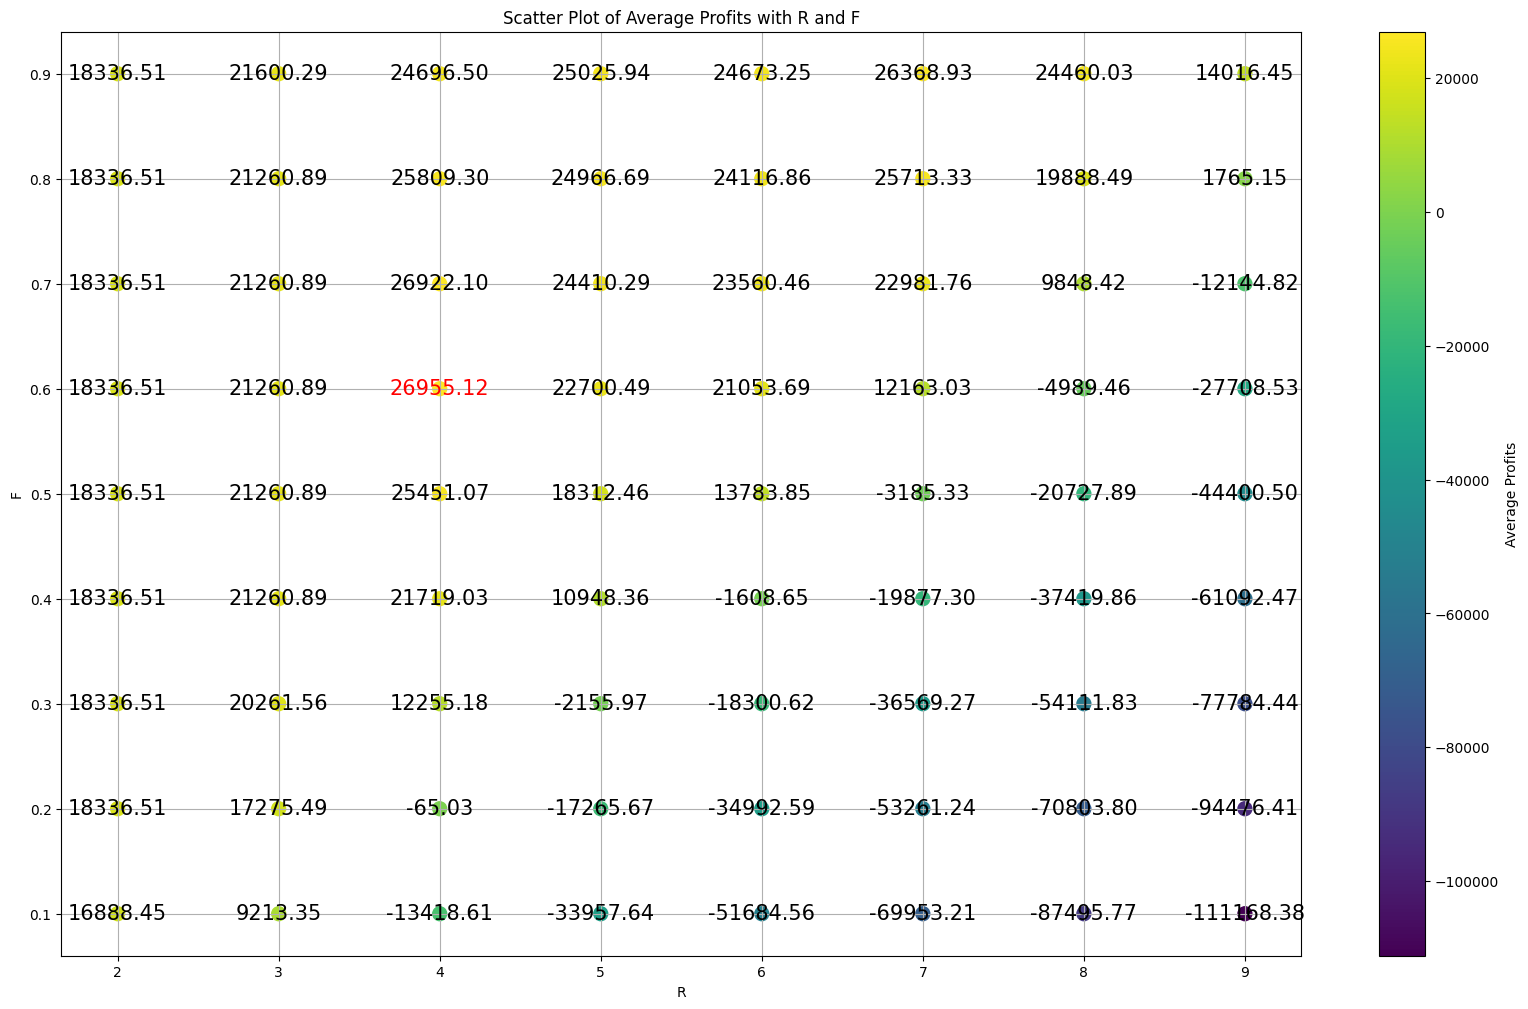

In [300]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

plt.show()

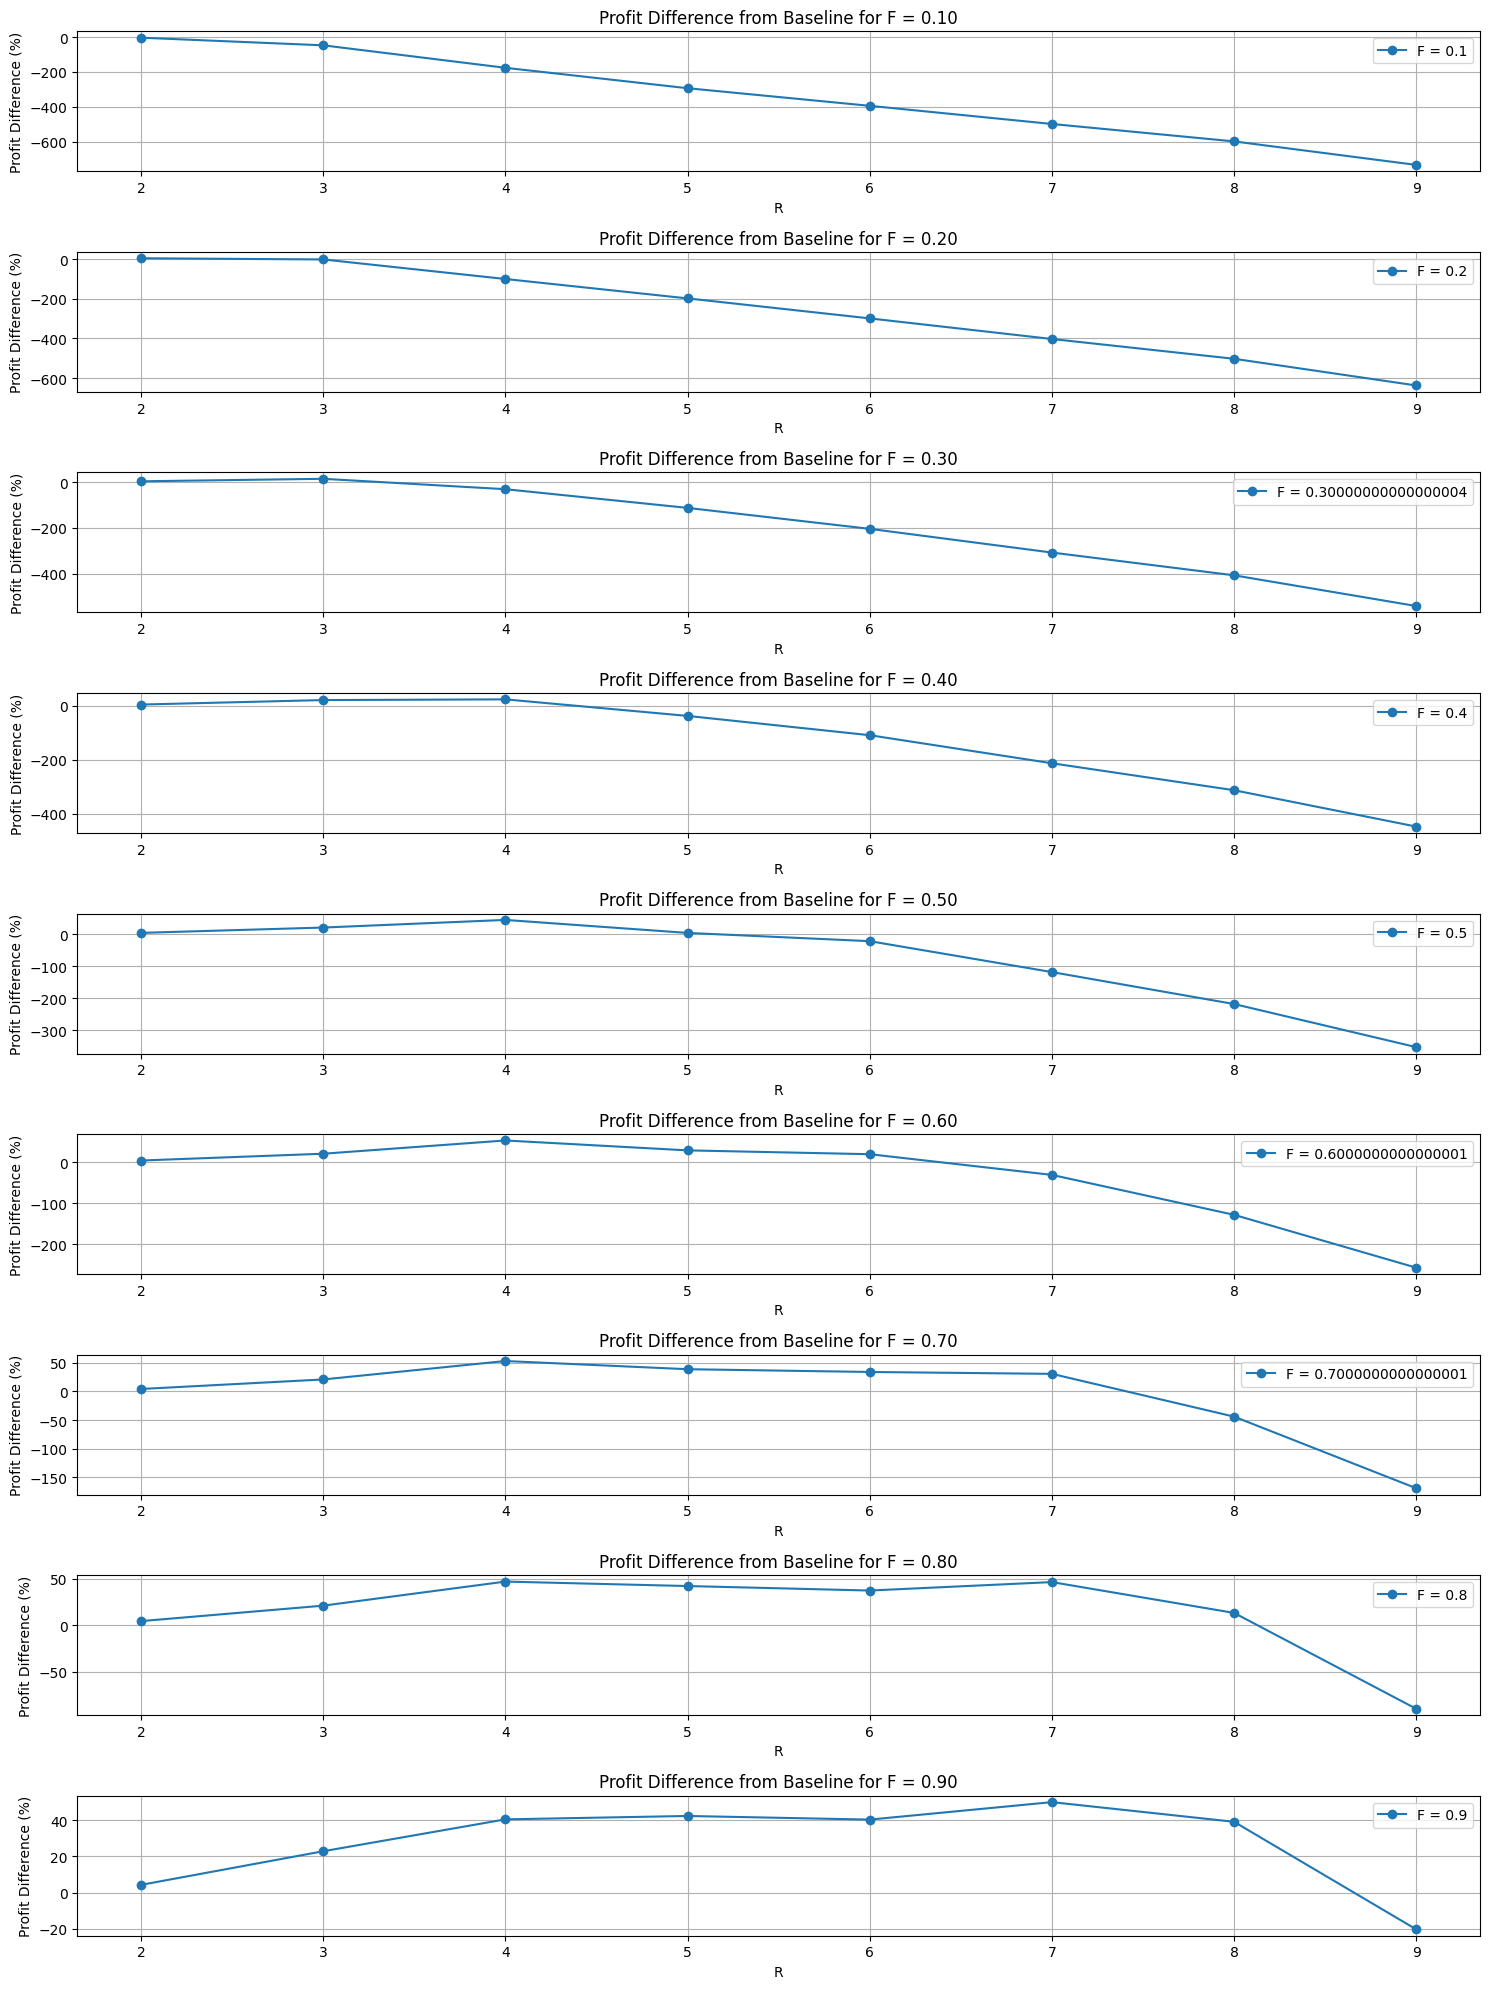

In [301]:
results_df_1["baseline_profit"] = baseline_profit

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_profit) / baseline_profit
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(assigned_Fs):
    plt.subplot(len(assigned_Fs), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R").dropna()
    plt.plot(
        subset["R"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

### (2)Grid for Fixed Rk & Flexible F


In [302]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts, salvage_value, cost, price
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 260 rows, 263 columns and 850 nonzeros
Model fingerprint: 0x654a4285
Model has 10 general constraints
Variable types: 183 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 168 rows and 139 columns
Presolve time: 0.00s
Presolved: 92 rows, 124 columns, 457 nonzeros
Variable types: 94 continuous, 30 integer (28 binary)

Root relaxation: objective 2.958304e+05, 19 ite

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/2368898064.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/2368898064.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/2368898064.py:77: FutureWarning: Series.__getitem

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 260 rows, 263 columns and 850 nonzeros
Model fingerprint: 0x07fe25af
Model has 10 general constraints
Variable types: 183 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 60 rows and 10 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
===================== 找不到最佳解 ==================
Model is feasible. Status: 4
Academic license 2563044 - for

,T,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,F_vars,Q0_vars,Q1_vars
1,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",0.0,101.930301,32914.666807,29618.747617,"[0.04619845022021439, 0.26204821082410523, 0.0]","[0.9843149371489296, 0.7463913613133367, 0.985...","[136.91796169594204, 103.82285177393298, 137.1...","[0.0, 40.45638940129784, 40.456521089684884, 4..."
2,4,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",0.0,77.421431,32914.666807,29606.298013,"[0.04748532668164326, 0.0, 0.0]","[0.7026088277523119, 0.901188593018807, 0.9330...","[97.73271230046008, 125.35510800757038, 129.79...","[40.4563887276732, 40.45649459077433, 40.45650..."
0,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",0.0,111.289932,32914.666807,29583.041292,"[0.0, 0.0, 1.8653397262555325]","[0.7140969395209579, 0.7637173620146761, 0.865...","[99.33070577565223, 106.23289414029293, 120.44...","[40.45648331001112, 40.456498340139404, 40.456..."


In [303]:
if results_df_2 is not None:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/low_s2.pkl


In [304]:
stimulation_results_df_2

,R,F,profits,losses,lefts,operation_profits
0,3,0.984315,30952.624097,0.0,134.401049,30952.624097
1,3,0.746391,35117.397465,0.0,93.677606,35117.397465
2,3,0.985746,39128.231192,0.0,87.059398,39128.231192
3,3,0.789127,35364.026978,0.0,98.227210,35364.026978
4,3,0.988058,-13711.260926,0.0,154.727648,19247.930974
5,3,0.790303,32384.614480,0.0,80.672377,32384.614480
6,3,0.740179,32023.928111,0.0,87.504192,32023.928111
7,3,0.676570,40149.652043,0.0,130.223178,40149.652043
8,3,0.853624,36616.312434,0.0,89.908723,36616.312434
9,3,0.713492,28161.950297,0.0,62.901628,28161.950297


In [305]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["T", "average_profits"]]
top_three_info

,T,average_profits
1,3,29618.747617
2,4,29606.298013
0,2,29583.041292


### (4)Grid for Fixed F & Flexible Rk


In [306]:
assigned_Fs = np.arange(0.1, 1.0, 0.1)

results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = grid_fixed_F_flexible_R(
    assigned_Fs, salvage_value, cost, price
)
results_df_4

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 490 rows, 578 columns and 1490 nonzeros
Model fingerprint: 0x1e714e78
Model has 70 quadratic constraints
Model has 160 general constraints
Variable types: 498 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 200 rows and 151 columns
Presolve time: 0.00s

Explor

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/4209178438.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")


        6         6         6         1         1         1           0s

IIS computed: 6 constraints, 1 bounds
IIS runtime: 0.01 seconds (0.00 work units)
導致不可行的約束： R98
導致不可行的約束： Q0_upper_bound_2
導致不可行的約束： Ensure_only_one_R_true_2
導致不可行的約束： Define_Q_hat_2
導致不可行的約束： Adjust_Q_hat_2
導致不可行的約束： Constr_Q1_ge_Q_hat_adjusted_2
導致不可行的變量： Q1_var[2], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is F=0.8 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 490 rows, 578 columns and 1490 nonzeros
Model fingerprint: 0x308e6e2e
Model has 70 quadratic constraints
Model has 160 general constraints
Variable types: 4

,R,average_losses,average_lefts,average_operation_profits,average_profits,beta_values,F_vars,Q0_vars,Q1_vars
0,"[9, 2, 2, 5, 9, 9, 9, 4, 6, 9]",1.13016,58.841491,32688.634784,29836.304253,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, ...","[125.18977501578173, 125.18977501578173, 125.1...","[24.455388668977534, 21.499617464650598, 35.71..."


In [307]:
if results_df_4 is not None:
    save_model_parameters("f"{model_prefix}_s4", beta_values=results_df_4.iloc[0]['beta_values'])


SyntaxError: unterminated string literal (detected at line 2) (1258026556.py, line 2)

In [258]:
for beta in results_df_4["beta_values"]:
    print(f"beta: \n{beta}")
    print(f"\n")

beta: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]




In [259]:
stimulation_results_df_4

,R,F,profits,losses,lefts,operation_profits
0,9,0.9,28934.842719,5.044453,0.073503,29943.733408
1,2,0.9,35117.397465,0.000000,127.157734,35117.397465
2,2,0.9,39128.231192,0.000000,119.468894,39128.231192
3,5,0.9,35364.026978,0.000000,73.101670,35364.026978
4,9,0.9,-3912.165141,0.000000,65.811132,19247.930974
5,9,0.9,32384.614480,0.000000,3.844836,32384.614480
6,9,0.9,32023.928111,0.000000,9.903979,32023.928111
7,4,0.9,40149.652043,0.000000,135.457260,40149.652043
8,6,0.9,36616.312434,0.000000,49.717293,36616.312434
9,9,0.9,22556.202247,6.257148,3.878611,26910.520751


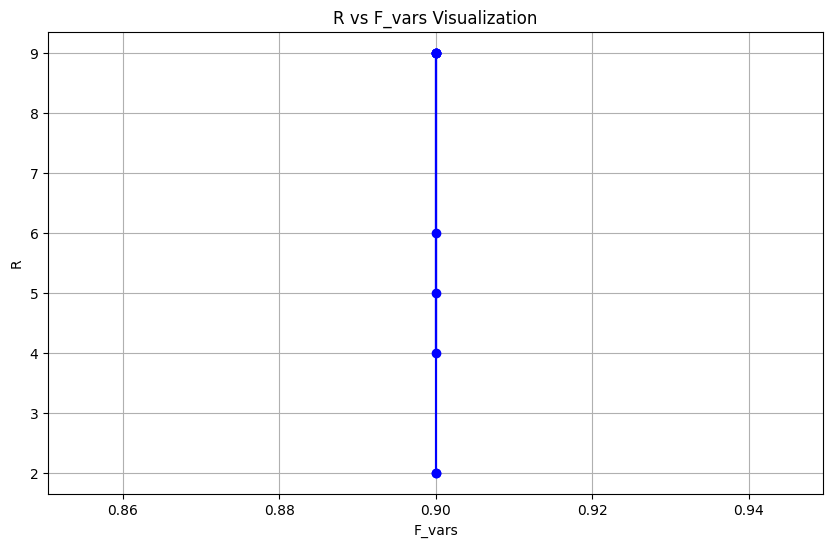

In [260]:
# 提取 'R' 和 'F_vars' 列中的列表值
r_values = results_df_4["R"].explode().values  # 将所有列表中的值展开成一个长序列
f_values = results_df_4["F_vars"].explode().values  # 将所有列表中的值展开成一个长序列

# 创建图表
plt.figure(figsize=(10, 6))
plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

# 设置图表标题和轴标签
plt.title("R vs F_vars Visualization")
plt.xlabel("F_vars")
plt.ylabel("R")

plt.grid(True)
plt.show()

### (3)Fully flexible F & Rk


#### (5)Simple beta with softmax


In [261]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 1500
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 490 rows, 625 columns and 1400 nonzeros
Model fingerprint: 0xa3ed6b36
Model has 80 quadratic constraints
Model has 180 general constraints
Variable types: 545 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 115 rows and 12434 columns
Presolve time: 0.07s
Presolved: 3645 rows, 13779 columns, 47537 nonzeros
Presolved model has 9

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3617907323.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")


     0     0 329146.668    0  691          - 329146.668      -     -    0s
     0     0 329146.668    0  691          - 329146.668      -     -    0s
     0     0 329146.668    0  733          - 329146.668      -     -    0s
     0     0 329146.668    0  733          - 329146.668      -     -    0s
     0     2 329146.668    0  733          - 329146.668      -     -    0s
  5026  1838 296860.094  225  744          - 310438.563      -  61.4    5s
  6728  2145 310438.563   25  748          - 310438.563      -  57.7   10s
  7193  2484 310438.563   57  845          - 310438.563      -  71.6   15s
* 9194  2197             212    308123.46928 310438.563  0.75%  73.7   18s

Cutting planes:
  RLT: 7

Explored 9656 nodes (700754 simplex iterations) in 18.25 seconds (32.17 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 308123 

Optimal solution found (tolerance 3.00e-01)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust

,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,beta_values,F_vars,Q0_vars,Q1_vars
0,"[8, 3, 2, 2, 5, 2, 2, 2, 3, 5]",0.0,104.257833,32914.666807,30812.346928,"[0.0, 0.0, 2.0]","[[-0.08949051923568178], [-0.08949069026857615...","[0.8807970779778823, 0.8807970779778823, 0.865...","[122.51865336289895, 122.51865336289895, 120.4...","[23.218599811688122, 40.456521089684195, 40.45..."


In [262]:
if results_df_5 is not None:
    save_model_parameters(
        "f"{model_prefix}_s5", 
        alpha_values=results_df_5.iloc[0]['alpha_values'], 
        beta_values=results_df_5.iloc[0]['beta_values']
    )

Model parameters saved as models/low_s5.pkl


In [263]:
stimulation_results_df_5

,R,F,profits,losses,lefts,operation_profits
0,8,0.880797,30952.624097,0.0,13.984679,30952.624097
1,3,0.880797,35117.397465,0.0,93.677474,35117.397465
2,2,0.865918,39128.231192,0.0,114.728114,39128.231192
3,2,0.880797,35364.026978,0.0,156.615136,35364.026978
4,5,0.880797,-1775.267819,0.0,85.938149,19247.930974
5,2,0.880797,32384.614480,0.0,130.369712,32384.614480
6,2,0.880797,32023.928111,0.0,147.908924,32023.928111
7,2,0.880797,40149.652043,0.0,145.105499,40149.652043
8,3,0.853624,36616.312434,0.0,89.908664,36616.312434
9,5,0.880797,28161.950297,0.0,64.341984,28161.950297


#### (6)Simple beta and softmax with T is 1 - sum(T-1)


In [264]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 1500
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 490 rows, 591 columns and 1520 nonzeros
Model fingerprint: 0x880aef63
Model has 70 quadratic constraints
Model has 170 general constraints
Variable types: 511 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 105 rows and 10907 columns
Presolve time: 0.05s
Presolved: 875 rows, 11498 columns, 35077 nonzeros
Presolved model has 80

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/4086288146.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")


,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,beta_values,F_vars,Q0_vars,Q1_vars
0,"[9, 6, 3, 9, 4, 9, 3, 3, 6, 6]",0.0,65.648596,32914.666807,29513.374396,"[0.0, 0.27977222726015716, 9.097460421638974]","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[0.9999516394164341, 0.9999516394164341, 0.999...","[139.09302307245053, 139.09302307245053, 139.0...","[10.552140612308733, 30.927180407519245, 38.52..."


In [265]:
if results_df_6 is not None:
    save_model_parameters(
        "f"{model_prefix}_s6", 
        alpha_values=results_df_6.iloc[0]['alpha_values'], 
        beta_values=results_df_6.iloc[0]['beta_values']
    )

Model parameters saved as models/low_s6.pkl


In [266]:
stimulation_results_df_6

,R,F,profits,losses,lefts,operation_profits
0,9,0.999952,30952.624097,0.0,13.976751,30952.624097
1,6,0.999952,35117.397465,0.0,52.461493,35117.397465
2,3,0.999607,39128.231192,0.0,88.987410,39128.231192
3,9,0.999779,35364.026978,0.0,0.000000,35364.026978
4,4,0.997527,-14764.993138,0.0,131.730734,19247.930974
5,9,0.993307,32384.614480,0.0,15.830598,32384.614480
6,3,0.997527,32023.928111,0.0,123.301259,32023.928111
7,3,0.997527,40149.652043,0.0,130.223178,40149.652043
8,6,0.999779,36616.312434,0.0,48.194728,36616.312434
9,6,0.997527,28161.950297,0.0,51.779812,28161.950297


#### (3)Simple beat and softmax with T is 1 - sum(T-1) & tau with f


這是將 tau = beta + f 進行計算的部分


In [267]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = fully_flexible_simple_beta_with_softmax_3(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_3

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 1500
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 490 rows, 591 columns and 1590 nonzeros
Model fingerprint: 0x90600fc3
Model has 70 quadratic constraints
Model has 170 general constraints
Variable types: 511 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/262902676.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")


Presolve added 175 rows and 10977 columns
Presolve time: 0.05s
Presolved: 945 rows, 11568 columns, 35287 nonzeros
Presolved model has 80 SOS constraint(s)
Presolved model has 70 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 11417 continuous, 151 integer (151 binary)

Root relaxation: objective 3.291467e+05, 818 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 329146.668    0  105          - 329146.668      -     -    0s
     0     0 329146.668    0  105          - 329146.668      -     -    0s
     0     0 329146.668    0  105          - 329146.668      -     -    0s
H    0     0                    294858.59195 329146.668  11.6%     -    0s

Explored 1 nodes (1288 simplex iterations) in 0.14 seconds (0.15 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 294859 

Optimal solution 

,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,beta_values,F_vars,Q0_vars,Q1_vars
0,"[9, 3, 4, 9, 9, 9, 4, 6, 6, 9]",0.0,54.564945,32914.666807,29485.859195,"[0.0, 0.0, 1000000.0]","[[-1000000.0], [-1000000.0], [-1000000.0], [-1...","[1.0, 1.0, 1.0, 0.9999999902653044, 1.0, 1.0, ...","[139.09975001753526, 139.09975001753526, 139.0...","[10.545413667224004, 5.17949115769553, 31.1477..."


In [268]:
if results_df_3 is not None:
    save_model_parameters(
        "f"{model_prefix}_s3", 
        alpha_values=results_df_6.iloc[0]['alpha_values'], 
        beta_values=results_df_6.iloc[0]['beta_values']
    )

Model parameters saved as models/low_s3.pkl


In [269]:
stimulation_results_df_3

,R,F,profits,losses,lefts,operation_profits
0,9,1.0,30952.624097,0.0,13.983478,30952.624097
1,3,1.0,35117.397465,0.0,128.954504,35117.397465
2,4,1.0,39128.231192,0.0,57.016123,39128.231192
3,9,1.0,35364.026978,0.0,0.030690,35364.026978
4,9,1.0,-15040.145142,0.0,93.631082,19247.930974
5,9,1.0,32384.614480,0.0,17.754811,32384.614480
6,4,1.0,32023.928111,0.0,102.029450,32023.928111
7,6,1.0,40149.652043,0.0,74.691760,40149.652043
8,6,1.0,36616.312434,0.0,48.194728,36616.312434
9,9,1.0,28161.950297,0.0,9.362829,28161.950297


#### (7)Beta with softmax


In [270]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 1500
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 490 rows, 617 columns and 1560 nonzeros
Model fingerprint: 0x6dac8094
Model has 80 quadratic constraints
Model has 180 general constraints
Variable types: 537 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/1474301460.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(Q_hats[i] == gp.quicksum(R_vars[i, k-2] * Qk_hat_df_row[k-2] for k in range(2, T)), name=f"Define_Q_hat_{i}")


Presolve added 195 rows and 12538 columns
Presolve time: 0.07s
Presolved: 2495 rows, 13565 columns, 44187 nonzeros
Presolved model has 90 SOS constraint(s)
Presolved model has 420 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 13414 continuous, 151 integer (151 binary)

Root relaxation: objective 3.291467e+05, 575 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 329146.668    0  169          - 329146.668      -     -    0s
     0     0 329146.668    0  167          - 329146.668      -     -    0s
     0     0 329146.668    0  167          - 329146.668      -     -    0s
     0     0 329146.668    0  217          - 329146.668      -     -    0s
     0     0 329146.668    0  220          - 329146.668      -     -    0s
     0     0 329146.668    0  218          - 329146.668      -     -    0s
     0     0 329146.

,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,beta_values,F_vars,Q0_vars,Q1_vars
0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",0.0,127.797564,32914.666807,29583.041292,"[0.0, 0.0, 2.0]","[[-2.281507933063693e-06], [0.0], [0.279545544...","[0.8807970779778823, 0.8807970779778823, 0.865...","[122.51865336289895, 122.51865336289895, 120.4...","[17.268535722764412, 40.456521089684195, 40.45..."


In [271]:
if results_df_7 is not None:
    save_model_parameters(
        "f"{model_prefix}_s7", 
        alpha_values=results_df_6.iloc[0]['alpha_values'], 
        beta_values=results_df_6.iloc[0]['beta_values']
    )

Model parameters saved as models/low_s7.pkl


In [272]:
results_df_7

,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,beta_values,F_vars,Q0_vars,Q1_vars
0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",0.0,127.797564,32914.666807,29583.041292,"[0.0, 0.0, 2.0]","[[-2.281507933063693e-06], [0.0], [0.279545544...","[0.8807970779778823, 0.8807970779778823, 0.865...","[122.51865336289895, 122.51865336289895, 120.4...","[17.268535722764412, 40.456521089684195, 40.45..."


In [273]:
stimulation_results_df_7

,R,F,profits,losses,lefts,operation_profits
0,2,0.880797,30952.624097,0.0,117.132513,30952.624097
1,2,0.880797,35117.397465,0.0,108.200830,35117.397465
2,2,0.865918,39128.231192,0.0,114.728114,39128.231192
3,2,0.880797,35364.026978,0.0,156.615136,35364.026978
4,2,0.880797,-11537.631618,0.0,145.458522,19247.930974
5,2,0.880797,32384.614480,0.0,130.369712,32384.614480
6,2,0.880797,32023.928111,0.0,147.908924,32023.928111
7,2,0.880797,40149.652043,0.0,145.105499,40149.652043
8,2,0.798291,36616.312434,0.0,111.119423,36616.312434
9,2,0.880797,25631.257741,0.0,101.336965,28161.950297


In [319]:
show_models(model_prefix)

Contents of models/low_s3.pkl:
{'alpha': array([0.        , 0.27977223, 9.09746042]), 'beta': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])}

Contents of models/low_s2.pkl:
{'alpha': array([0.04619845, 0.26204821, 0.        ])}

Contents of models/low_s5.pkl:
{'alpha': array([0., 0., 2.]), 'beta': array([[-0.08949052],
       [-0.08949069],
       [-0.00212965],
       [-0.08949069],
       [ 0.        ],
       [-0.00054055],
       [-0.08949069],
       [-0.08949052]])}

Contents of models/low_s4.pkl:
{'beta': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])}

Contents of models/low_s6.pkl:
{'alpha': array([0.        , 0.27977223, 9.09746042]), 'beta': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])}

Contents of models/low_s7.pkl:
{'alpha': array([0.        , 0.27977223, 9.09746042]), 'beta': array([[0.],
       [

## Analysis


### 單次進貨策略


In [274]:
print(f"The Average profit of One-time procurement: {baseline_profit}")

The Average profit of One-time procurement: 17582.021782513028


### 策略一


In [275]:
# 策略一
results_df_1

,R,F,Q0,average_profits,average_losses,average_lefts,average_operation_profits,baseline_profit,profit_diff_percent
23,4,0.6,83.459850,26955.120480,14.699587,0.099639,29974.749327,17582.021783,53.310699
24,4,0.7,97.369825,26922.100976,14.556102,0.212656,30003.446381,17582.021783,53.122896
53,7,0.9,125.189775,26368.931462,6.573091,4.895624,31600.048609,17582.021783,49.976674
25,4,0.8,111.279800,25809.302975,14.556102,1.603654,30003.446381,17582.021783,46.793715
52,7,0.8,111.279800,25713.328981,8.046758,4.978293,31305.315195,17582.021783,46.247851
...,...,...,...,...,...,...,...,...,...
55,8,0.2,27.819950,-70803.800830,89.538074,84.879047,15007.051982,17582.021783,-502.705683
65,9,0.3,41.729925,-77784.443035,93.615939,91.565918,14191.479050,17582.021783,-542.408979
54,8,0.1,13.909975,-87495.770832,103.448049,98.789022,12225.056981,17582.021783,-597.643399
64,9,0.2,27.819950,-94476.413037,107.525914,105.475893,11409.484050,17582.021783,-637.346695


In [276]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：-2330.8048292063345
策略1最佳策略在：R=4.0, F=0.6000000000000001
策略1最佳策略之下最大利潤為：26955.1204795773


### 策略二


In [277]:
# 策略二
results_df_2

,T,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,F_vars,Q0_vars,Q1_vars
1,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",0.0,101.930301,32914.666807,29618.747617,"[0.04619845022021439, 0.26204821082410523, 0.0]","[0.9843149371489296, 0.7463913613133367, 0.985...","[136.91796169594204, 103.82285177393298, 137.1...","[0.0, 40.45638940129784, 40.456521089684884, 4..."
2,4,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]",0.0,77.421431,32914.666807,29606.298013,"[0.04748532668164326, 0.0, 0.0]","[0.7026088277523119, 0.901188593018807, 0.9330...","[97.73271230046008, 125.35510800757038, 129.79...","[40.4563887276732, 40.45649459077433, 40.45650..."
0,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",0.0,111.289932,32914.666807,29583.041292,"[0.0, 0.0, 1.8653397262555325]","[0.7140969395209579, 0.7637173620146761, 0.865...","[99.33070577565223, 106.23289414029293, 120.44...","[40.45648331001112, 40.456498340139404, 40.456..."


In [278]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['T']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：29602.6956406924
策略2最佳策略在：R=3, F為彈性
策略2最佳策略之下最大利潤為：29618.74761700635


### 策略三


In [279]:
# 策略三
results_df_3

,R,average_losses,average_lefts,average_operation_profits,average_profits,alpha_values,beta_values,F_vars,Q0_vars,Q1_vars
0,"[9, 3, 4, 9, 9, 9, 4, 6, 6, 9]",0.0,54.564945,32914.666807,29485.859195,"[0.0, 0.0, 1000000.0]","[[-1000000.0], [-1000000.0], [-1000000.0], [-1...","[1.0, 1.0, 1.0, 0.9999999902653044, 1.0, 1.0, ...","[139.09975001753526, 139.09975001753526, 139.0...","[10.545413667224004, 5.17949115769553, 31.1477..."


In [280]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = results_df_3.loc[results_df_3["average_profits"].idxmax()]
    max_profit_for_s3 = max_profit_row["average_profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R']}, \nF={max_profit_row['F_vars']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

策略3最佳策略在：
R=[9, 3, 4, 9, 9, 9, 4, 6, 6, 9], 
F=[1.0, 1.0, 1.0, 0.9999999902653044, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
策略3最佳策略之下最大利潤(Avg profit)為：29485.859195333738


### 策略四


In [281]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略在：\nR={max_profit_row['R']}, \nF={max_profit_row['F_vars']}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

策略4最佳策略在：
R=[9, 2, 2, 5, 9, 9, 9, 4, 6, 9], 
F=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
策略4最佳策略之下最大利潤(Avg profit)為：29836.304252723756


### 策略五


In [282]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = results_df_5.loc[results_df_5["average_profits"].idxmax()]
    max_profit_for_s5 = max_profit_row["average_profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R']}, \nF={max_profit_row['F_vars']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

策略5最佳策略在：
R=[8, 3, 2, 2, 5, 2, 2, 2, 3, 5], 
F=[0.8807970779778823, 0.8807970779778823, 0.8659181234752235, 0.8807970779778823, 0.8807970779778823, 0.8807970779778823, 0.8807970779778823, 0.8807970779778823, 0.8536235702388096, 0.8807970779778823]
策略5最佳策略之下最大利潤(Avg profit)為：30812.34692770464


### 策略六


In [283]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = results_df_6.loc[results_df_6["average_profits"].idxmax()]
    max_profit_for_s6 = max_profit_row["average_profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R']}, \nF={max_profit_row['F_vars']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略在：
R=[9, 6, 3, 9, 4, 9, 3, 3, 6, 6], 
F=[0.9999516394164341, 0.9999516394164341, 0.9996070726189176, 0.9997793560176758, 0.9975273858858145, 0.9933071802445106, 0.9975273858858145, 0.9975273851940392, 0.9997793560176758, 0.9975273851940389]
策略6最佳策略之下最大利潤(Avg profit)為：29513.37439574758


### 策略七


In [284]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = results_df_7.loc[results_df_7["average_profits"].idxmax()]
    max_profit_for_s7 = max_profit_row["average_profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R']}, \nF={max_profit_row['F_vars']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

策略7最佳策略在：
R=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
F=[0.8807970779778823, 0.8807970779778823, 0.8659181234752185, 0.8807970779778823, 0.8807970779778823, 0.8807970779778823, 0.8807970779778823, 0.8807970779778823, 0.7982905365395142, 0.8807970779778823]
策略7最佳策略之下最大利潤(Avg profit)為：29583.04129216533


### 比較&分析


#### 不同策略 Scatter


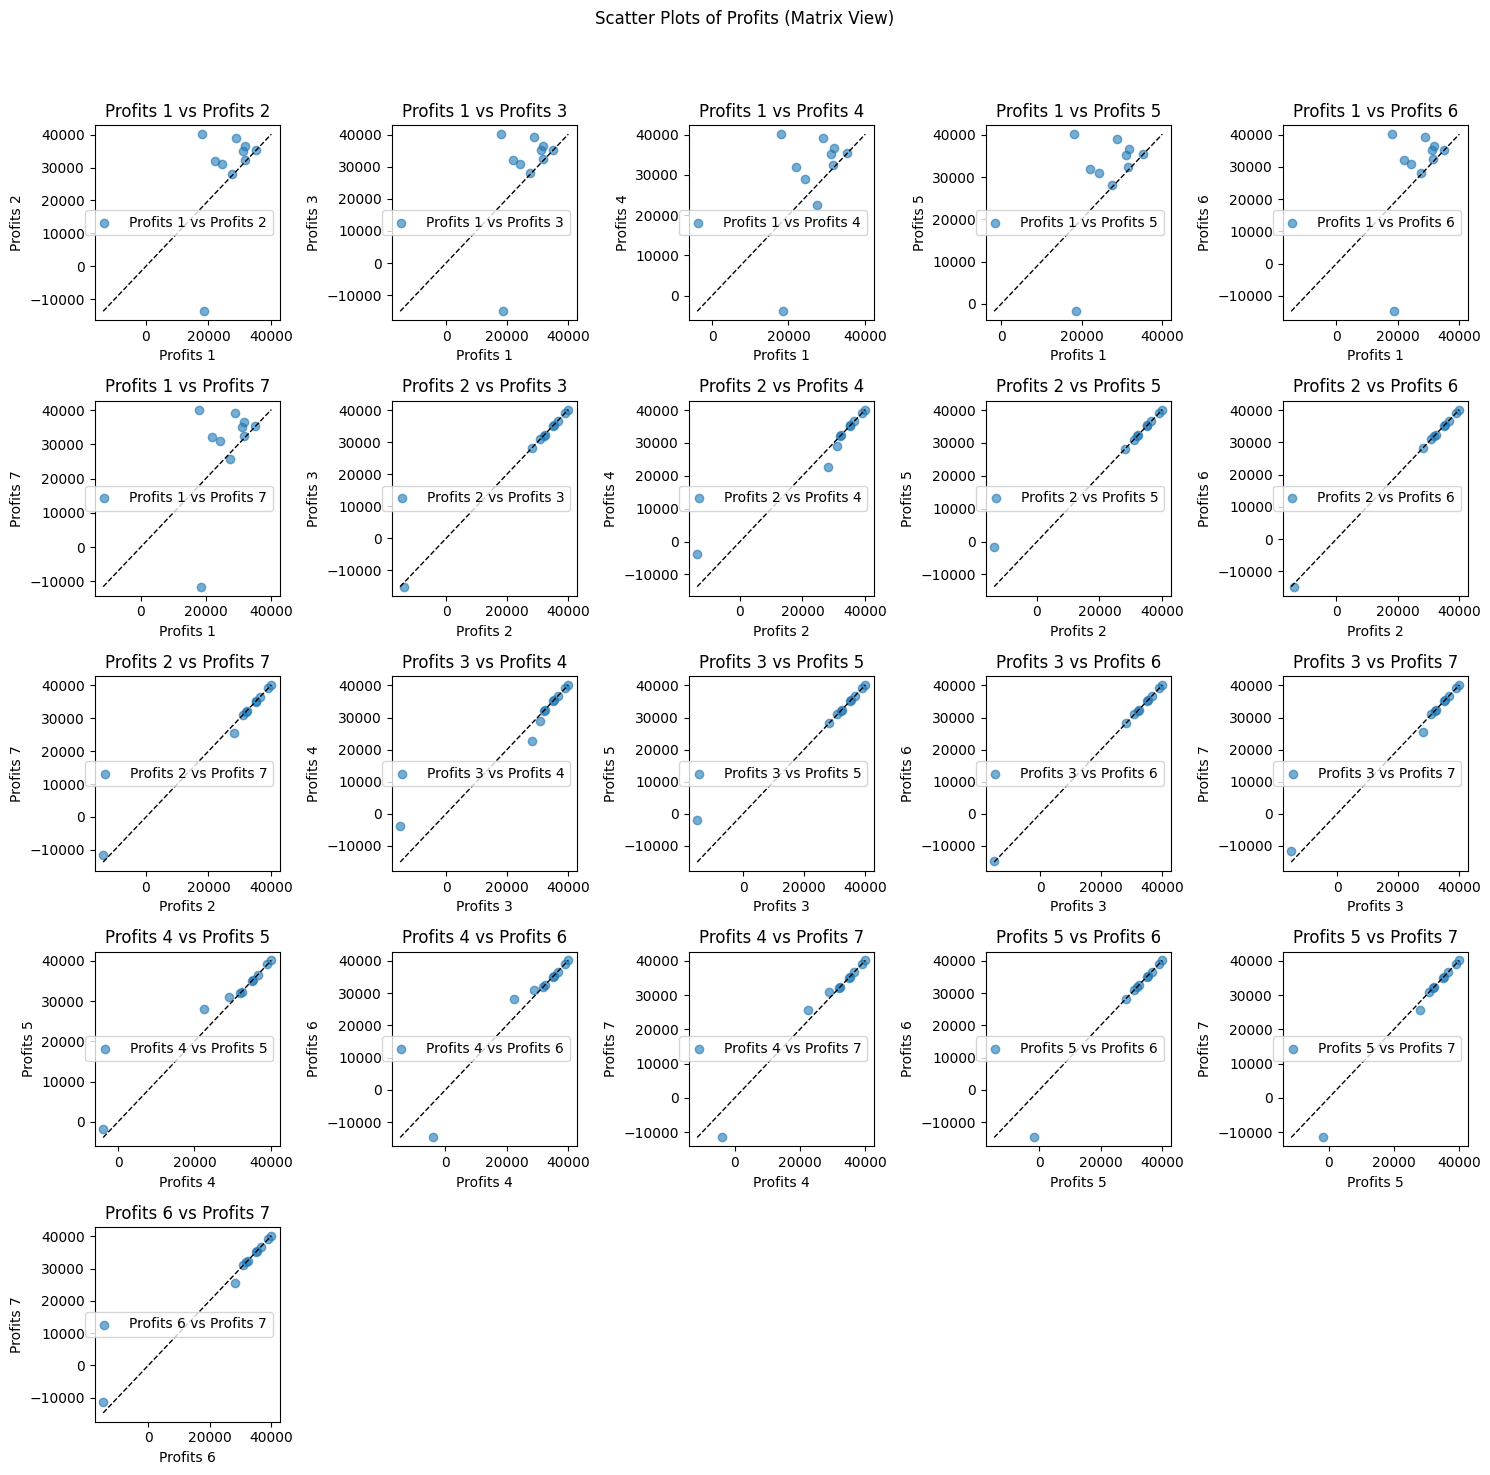

In [285]:
dfs = [
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
]
plot_strategies_profits_scatter(dfs)

#### 最大利潤比較


In [286]:
baseline_profit

np.float64(17582.021782513028)

Baseline is: 17582.021782513028
S1's profit: 26955.1204795773
S2's profit: 29618.74761700635
S3's profit: 29485.859195333738
S4's profit: 29836.304252723756
S5's profit: 30812.34692770464
S6's profit: 29513.37439574758
S7's profit: 29583.04129216533


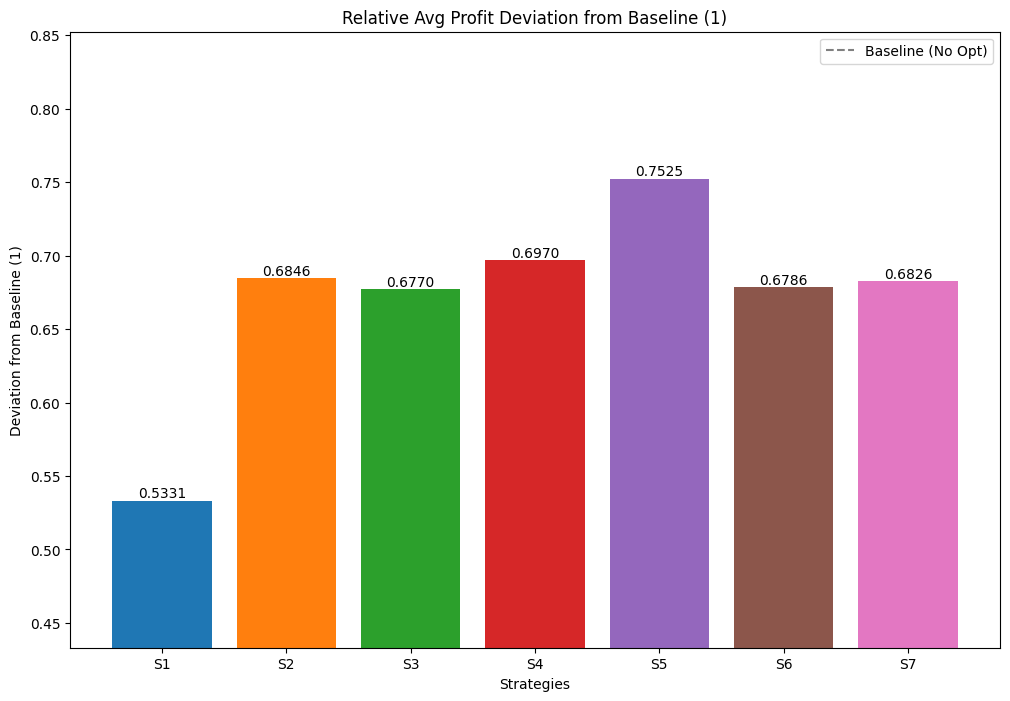

In [287]:
# 使用範例
max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
]

plot_relative_profit_deviation(float(baseline_profit), max_profits)

### Preparation


In [288]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7

# max value
low_baseline_profit = baseline_profit
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7

## Testing


### Setting reasonable parameters


In [410]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 153.00849680557707
std of sum: 17.232077124536602
20.0 percentile of sum: 138.50561479900097
Q_star: 138.50561479900097


In [409]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test

mu_matrix: [23.58068371 14.75938469 17.77567179 18.25327012 16.35821009 12.45984619
 16.87286775 12.94505872  7.9040481  12.94768173]
covariance_matrix: 
[[ 11.25597487  13.25921977   7.46539914   8.35631892  -6.90679015
   -9.22879172  -4.38261265  -5.92253479  -3.88989558  -4.52756984]
 [ 13.25921977  44.49092736  25.00738728  29.05706434 -32.9056579
   -2.10435995   2.14757846  -2.65174357  -8.15732973   5.40883311]
 [  7.46539914  25.00738728  14.10611547  15.33207758 -19.12710968
    0.29861118   2.24866621   0.28949288  -5.22149095   4.20622915]
 [  8.35631892  29.05706434  15.33207758  38.986562    -8.87819873
  -30.94721007 -19.39641953 -37.29996445   7.41223411 -19.74877748]
 [ -6.90679015 -32.9056579  -19.12710968  -8.87819873  33.59599348
  -20.91624372 -16.95881079 -22.85983785  13.52752518 -21.4243553 ]
 [ -9.22879172  -2.10435995   0.29861118 -30.94721007 -20.91624372
   55.02622098  37.25589894  59.72433511 -16.87376695  42.20162194]
 [ -4.38261265   2.14757846   2.24866

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3488690868.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3488690868.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3488690868.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3488690868.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3488690868.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576/3488690868.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_65576

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
16,139.173655,146.136998,175.113833,175.113833,175.113833,175.113833,175.113833,175.113833
17,135.397776,135.174444,155.790736,155.790737,155.790736,155.790737,155.790736,155.790737
18,138.407573,127.900470,128.088252,128.088253,128.088252,128.088253,128.088252,128.088253
19,137.451713,156.644312,156.434067,156.434068,156.434067,156.434068,156.434067,156.434068


### Run all the strategies


Baseline

S1

S2

S3

S4

S5

S6

S7

### Analysis

#### 組內比較

##### Profits Scatter

##### Profit Deviation

#### 訓練 vs. 測試

平均值比較

與各自的 Baseline 相比

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [ ]:
# 將變數名稱存取為此 Margin 特別的變數

# 總和分析


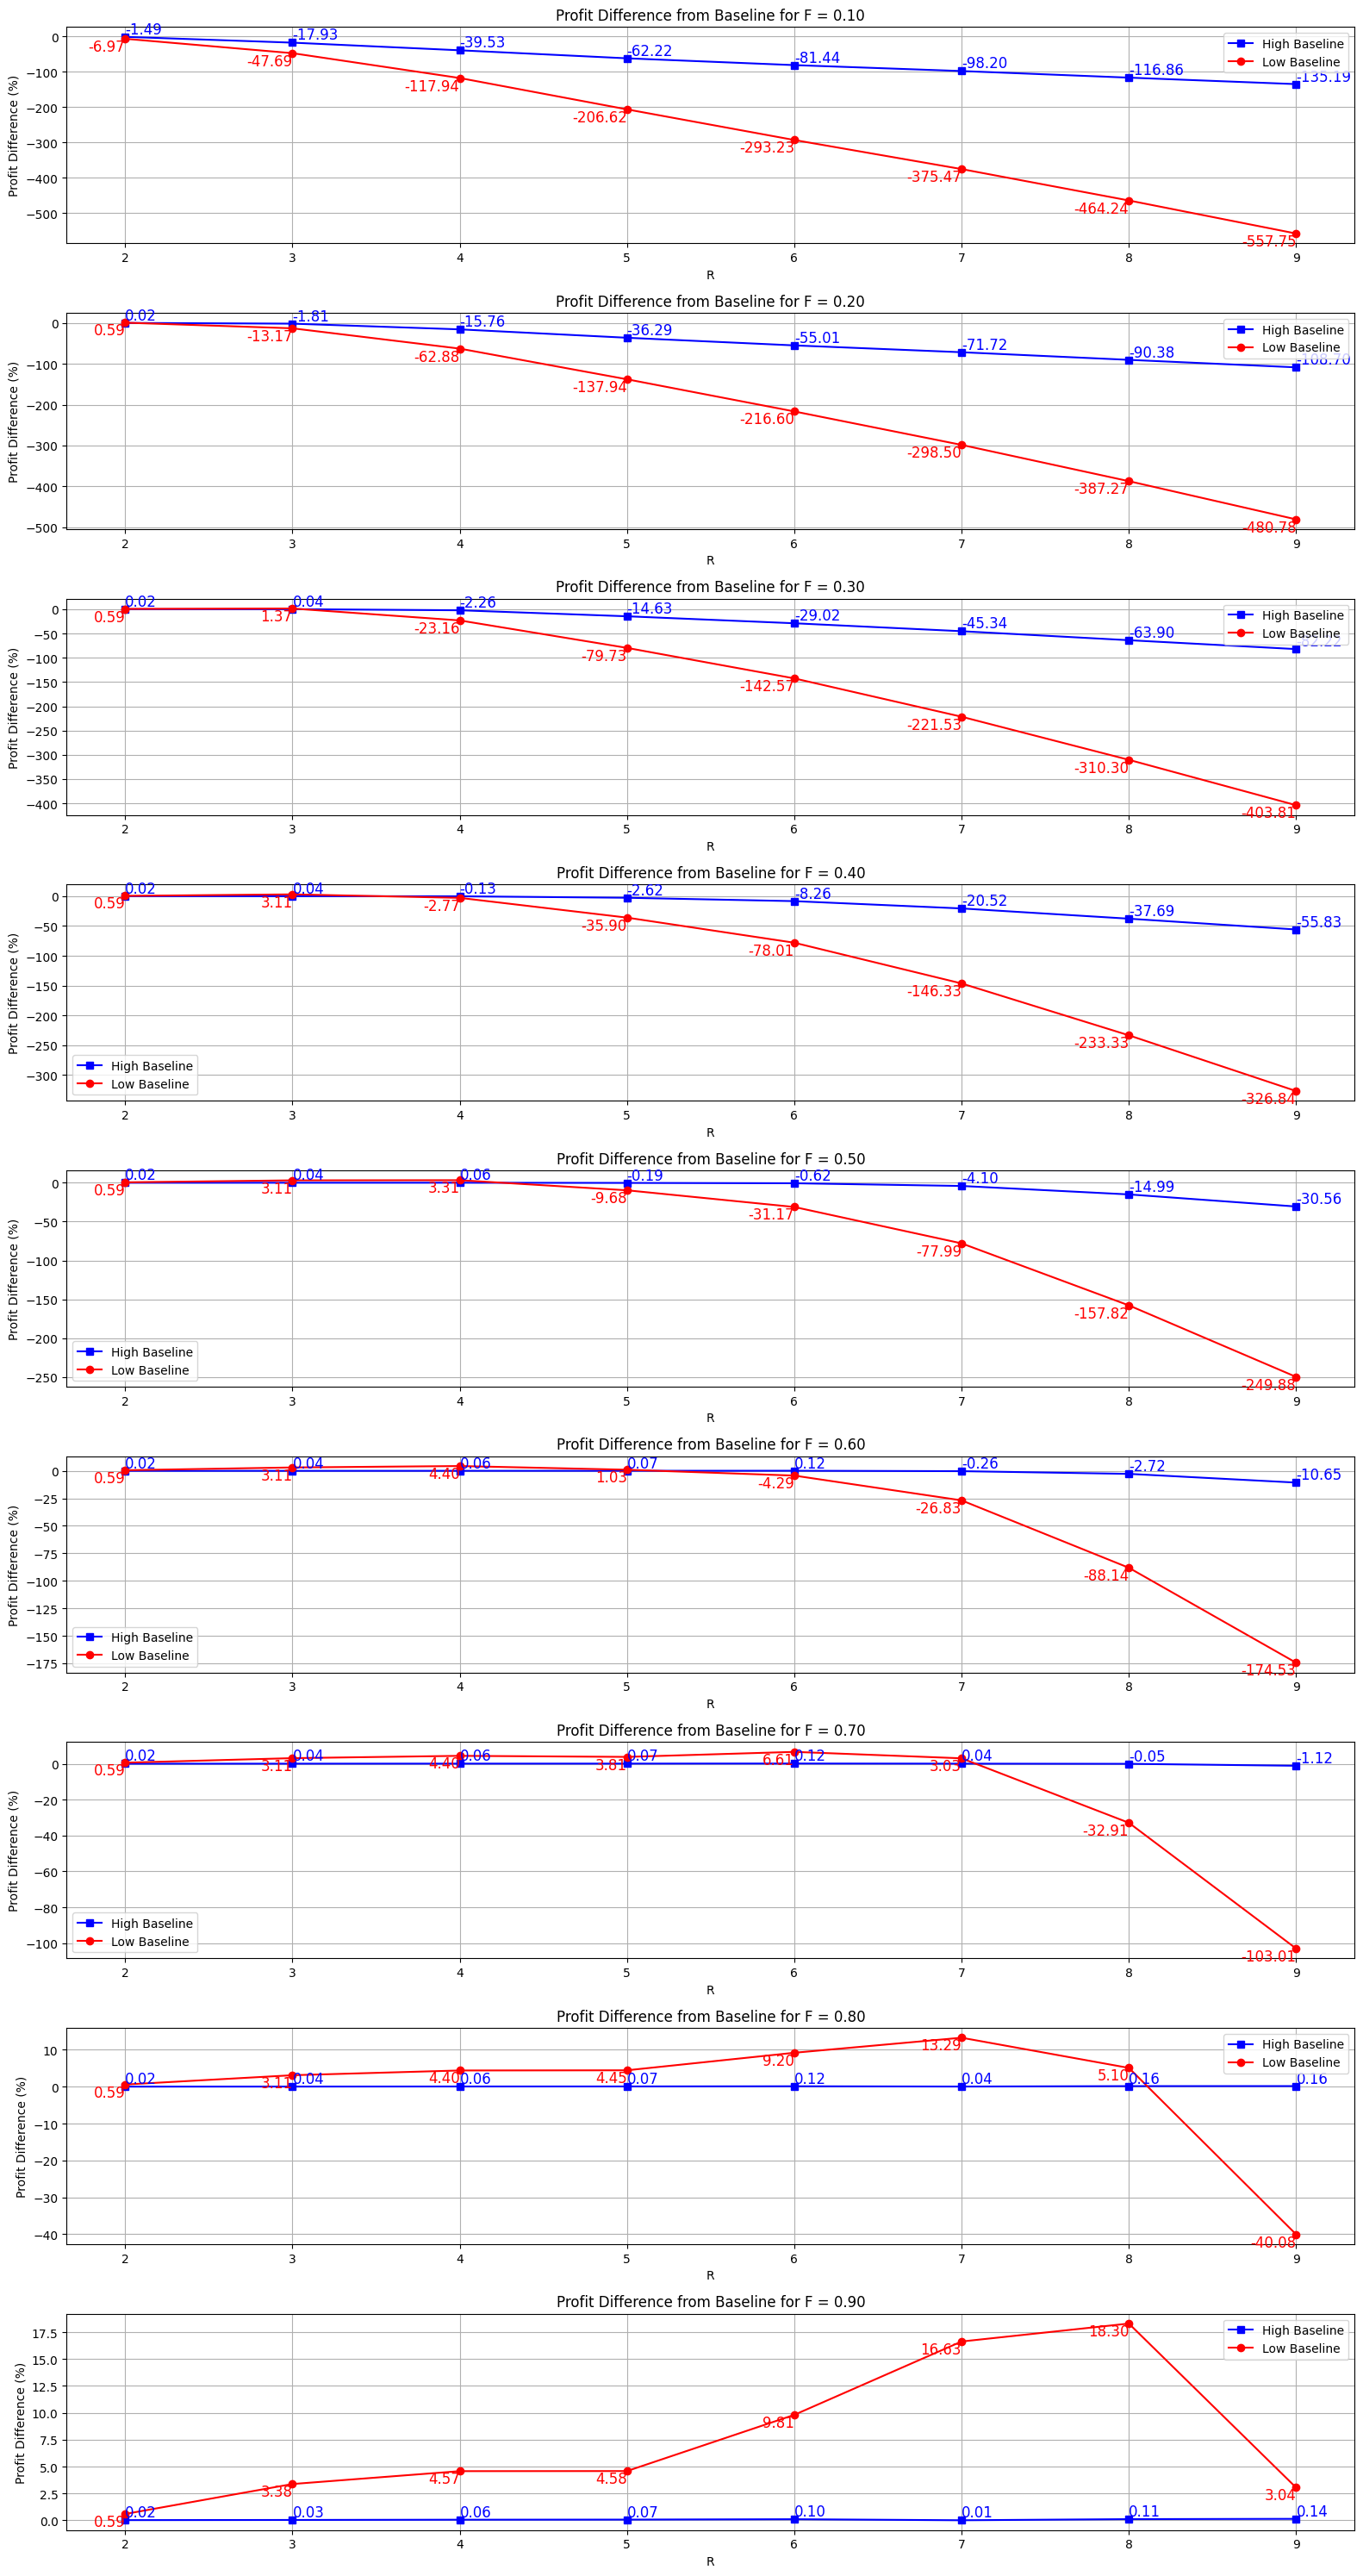

In [ ]:
# # Plotting
# plt.figure(figsize=(16, 30))

# # Traverse through different F values to plot merged subplots
# for idx, F in enumerate(assigned_Fs):
#     plt.subplot(len(assigned_Fs), 1, idx + 1)

#     # Select high baseline data corresponding to F
#     subset_high = (
#         high_results_df_1[high_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_high["R"],
#         subset_high["profit_diff_percent"],
#         marker="s",
#         linestyle="-",
#         color="blue",
#         label="High Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_high["R"], subset_high["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="blue", ha="left", va="bottom")

#     # Select low baseline data corresponding to F
#     subset_low = (
#         low_results_df_1[low_results_df_1["F"] == F].sort_values(by="R").dropna()
#     )
#     plt.plot(
#         subset_low["R"],
#         subset_low["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         color="red",
#         label="Low Baseline",
#     )

#     # Mark each data point with rounded value (up to two decimal places)
#     for x, y in zip(subset_low["R"], subset_low["profit_diff_percent"]):
#         plt.text(x, y, f"{y:.2f}", fontsize=12, color="red", ha="right", va="top")

#     plt.xlabel("R")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()
# plt.show()

# Drafts


In [ ]:
# def check_values(Q1, Q_hat_adjusted, Q0,
#                  Sold_0, total_demand_up_to_k_minus_1,
#                  Q0_var, Sold_1, total_demand_from_k_to_T,
#                  Q1_plus_left, Left_0, Lost_0, Left_1, Lost_1):

#     i=0
#     print("---------------------------------------")
#     print(f"Start to check the values: ")

#     # 檢查條件 1：Q1_vars[i].X 一定是等於 Q_hats[i].X - Q0_vars[i].X（值為 Q_hat_adjusted） 或是 0
#     if not (Q1 == Q_hat_adjusted or Q1 == 0):
#         print(f"Error: Q1 ({Q1}) should be equal to Q_hat_adjusted ({Q_hat_adjusted}) or 0")
#         i+=1

#     # 檢查條件 2：Sold_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X 或是 Q0_vars[i].X
#     if not (Sold_0 == total_demand_up_to_k_minus_1 or Sold_0 == Q0):
#         print(f"Error: Sold_0 ({Sold_0}) should be equal to total_demand_up_to_k_minus_1 ({total_demand_up_to_k_minus_1}) or Q0 ({Q0})")
#         i+=1

#     # 檢查條件 3：Sold_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X 或是 Q1_plus_lefts[i].X
#     if not (Sold_1 == total_demand_from_k_to_T or Sold_1 == Q1_plus_left):
#         print(f"Error: Sold_1 ({Sold_1}) should be equal to total_demand_from_k_to_T ({total_demand_from_k_to_T}) or Q1_plus_left ({Q1_plus_left})")
#         i+=1

#     # 檢查條件 4：Left_0s[i].X 一定等於 Q0_vars[i].X - Sold_0s[i].X 或是 0
#     if not (Left_0 == Q0 - Sold_0 or Left_0 == 0):
#         print(f"Error: Left_0 ({Left_0}) should be equal to Q0 - Sold_0 ({Q0 - Sold_0}) or 0")
#         i+=1

#     # 檢查條件 5：Left_1s[i].X 一定等於 Q1_plus_lefts[i].X - Sold_1s[i].X 或是 0
#     if not (Left_1 == Q1_plus_left - Sold_1 or Left_1 == 0):
#         print(f"Error: Left_1 ({Left_1}) should be equal to Q1_plus_left - Sold_1 ({Q1_plus_left - Sold_1}) or 0")
#         i+=1

#     # 檢查條件 6：Lost_0s[i].X 一定等於 total_demand_up_to_k_minus_1_vars[i].X - Q0_vars[i].X 或是 0
#     if not (Lost_0 == total_demand_up_to_k_minus_1 - Q0 or Lost_0 == 0):
#         print(f"Error: Lost_0 ({Lost_0}) should be equal to total_demand_up_to_k_minus_1 - Q0 ({total_demand_up_to_k_minus_1 - Q0}) or 0")
#         i+=1

#     # 檢查條件 7：Lost_1s[i].X 一定等於 total_demand_from_k_to_T_vars[i].X - Q1_plus_lefts[i].X 或是 0
#     if not (Lost_1 == total_demand_from_k_to_T - Q1_plus_left or Lost_1 == 0):
#         print(f"Error: Lost_1 ({Lost_1}) should be equal to total_demand_from_k_to_T - Q1_plus_left ({total_demand_from_k_to_T - Q1_plus_left}) or 0")
#         i+=1

#     if i == 0:
#         print(f"All Pass!")
#     else:
#         print(f"There are {i} wrongs!")

#     print("---------------------------------------")

In [ ]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addConstr(Left_0s[i] >= aux_left_0, name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")
# model.addConstr(Left_0s[i] <= aux_left_0, name=f"Constr_Left_0_3_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addConstr(Lost_0s[i] >= aux_lost_0, name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")
# model.addConstr(Lost_0s[i] <= aux_lost_0, name=f"Constr_Lost_0_3_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - Sold_1s[i], name=f"constr_aux_left_1_{i}")
# model.addConstr(Left_1s[i] >= aux_left_1, name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")
# model.addConstr(Left_1s[i] <= aux_left_1, name=f"Constr_Left_1_3_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addConstr(Lost_1s[i] >= aux_lost_1, name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")
# model.addConstr(Lost_1s[i] <= aux_lost_1, name=f"Constr_Lost_1_3_{i}")


# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [ ]:
# # ### 0~k-1 的需求量
# total_demand_up_to_k_minus_1_var = model.addVar(name=f"Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_var == gp.quicksum(R_vars[i, k-2] * demand_row[:k-1].sum() for k in range(2, T)), name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}")
# model.addConstr(total_demand_up_to_k_minus_1_vars[i] == total_demand_up_to_k_minus_1_var, name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}")

# # ### k~T 的需求量
# total_demand_from_k_to_T_var = model.addVar(name=f"Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_var == gp.quicksum(R_vars[i, k-2] * demand_row[k-1:].sum() for k in range(2, T)), name=f"Constr_Total_Demand_from_K_to_T_{i}")
# model.addConstr(total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var, name=f"Calculate_Total_Demand_from_k_to_T_{i}")

# # 計算 Sold_0
# model.addConstr(Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i], name=f"Constr_Sold_0_1_{i}")
# model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

# # 計算 Left_0
# model.addConstr(Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}")
# model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

# # 計算 Lost_0
# model.addConstr(Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"Constr_Lost_0_1_{i}")
# model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addConstr(Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Constr_Sold_1_1_{i}")
# model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

# # 計算 Left_1
# model.addConstr(Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}")
# model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

# # 計算 Lost_1
# model.addConstr(Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"Constr_Lost_1_1_{i}")
# model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

# # 統計本次 Profit for this stimulation
# model.addConstr(profits_vars[i] == (
#             (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
#             - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
#             - (cost - salvage_value) * Left_1s[i]  # left, only considering Left_1
# ), name=f"Profit_Constraint_{i}")

In [ ]:
# # 計算 Sold_0
# model.addGenConstrMin(Sold_0s[i], [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]], name=f"Sold_0_{i}")

# # 計算 Left_0
# aux_left_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_0_{i}")
# model.addConstr(aux_left_0 == Q0_vars[i] - Sold_0s[i], name=f"constr_aux_left_0_{i}")
# model.addGenConstrMax(Left_0s[i], [aux_left_0], 0.0, f"Left_0_Max_{i}")

# # 計算 Lost_0
# aux_lost_0 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_0_{i}")
# model.addConstr(aux_lost_0 == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], name=f"constr_aux_lost_0_{i}")
# model.addGenConstrMax(Lost_0s[i], [aux_lost_0], 0.0, f"Lost_0_Max_{i}")

# # 計算 Q1 + left_0
# model.addConstr(Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}")

# # 計算 Sold_1
# model.addGenConstrMin(Sold_1s[i], [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],  name=f"Sold_1_{i}")

# # 計算 Left_1
# aux_left_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_left_1_{i}")
# model.addConstr(aux_left_1 == Q1_plus_lefts[i] - total_demand_from_k_to_T_vars[i], name=f"constr_aux_left_1_{i}")
# model.addGenConstrMax(Left_1s[i], [aux_left_1], 0.0, f"Left_1_Max_{i}")

# # 計算 Lost_1
# aux_lost_1 = model.addVar(vtype=GRB.CONTINUOUS, name=f"aux_lost_1_{i}")
# model.addConstr(aux_lost_1 == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], name=f"constr_aux_lost_1_{i}")
# model.addGenConstrMax(Lost_1s[i], [aux_lost_1], 0.0, f"Lost_1_Max_{i}")